In [1]:
%matplotlib inline
from collections import Counter, OrderedDict, defaultdict
import copy
import glob
import itertools
from itertools import izip
import itertools
import os
import subprocess
import tempfile
import random

from IPython.core.display import HTML, Image
import itertools
import pandas as pd
from matplotlib import gridspec
from matplotlib import pyplot
import matplotlib.pyplot as plt

import matplotlib.patches as mpatches

import matplotlib as mpl
from matplotlib_venn import venn2, venn3
import numpy as np
import scipy
import seaborn as sns

from clipper.src import CLIP_analysis
from clipper.src import get_genomic_regions
import flotilla
from gscripts import GO
from gscripts.general import dataviz
from gscripts.general import parsers
from gscripts.general import region_helpers
from gscripts.rnaseq.helpers import counts_to_rpkm

img_dir = "/home/gpratt/Dropbox/mouse_stress/figures"

In [2]:
#Factor this to a helpers function
def gencode_to_ensembl(gene_list):
    for gene in gene_list:
        yield gene.split(".")[0]

In [3]:
legend = None

OUTSIDE_LEGEND_SAVEFIG_KWS = dict(bbox_extra_artists=(legend,),
                                  bbox_inches='tight')
from matplotlib import rc

mpl.rcParams['svg.fonttype'] = 'none'

rc('text', usetex=False) 
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [4]:
names = {'hWT': 'WT/GT-hWT',
         'gt': 'WT/GT',
         'rev': 'WT/WT',
         "q331k": 'WT/GT-hQ331K'}

Abbreviations used to represent cell lines:
 
1. Revertant cells have two copies of wild type mTDP43.  Labeled as “Rev”
2. Gene trap cells have only one copy of wild type mTDP43.  Labeled as “GT”
3. Transgenic human wild type cells have one copy of wild type hTDP43 and one copy of wild type mTDP43.  Labeled as “WT” or “hWT”
4. Transgenic human mutant cells have one copy of Q331K mutant hTDP43 and one copy of wild type mTDP43.  Labeled as “Q331K” or “hQ331K”
 
There are 6 tubes labeled 4 May 2015, differentiated and treated together as one experiment:
* 1 stressed Rev, 1 control Rev
* 1 stressed hWT, 1 control hWT
* 1 stressed hQ331K, 1 control hQ331K
 
There are 16 tubes labeled 6 July 2015, differentiated and treated together as one experiment:
* 2 stressed GT, 2 control GT
* 2 stressed Rev, 2 control Rev
* 2 stressed hWT, 2 control hWT
* 2 stressed hQ331K, 2 control hQ331K

In [5]:
gene_id_to_name = region_helpers.gene_id_to_name("/projects/ps-yeolab/genomes/mm10/gencode/gencode.vM3.annotation.gtf.db")
gene_id_to_name_hg19 = region_helpers.gene_id_to_name("/projects/ps-yeolab/genomes/hg19/gencode.v17.annotation.gtf.db")

gene_id_to_type = region_helpers.gene_id_to_type("/projects/ps-yeolab/genomes/mm10/gencode/gencode.vM3.annotation.gtf.db")
ensembl_id_to_name = {key.split(".")[0]: value for key, value in gene_id_to_name.items()}

name_to_gene_id = {value: key for key, value in gene_id_to_name.items()}

In [6]:
av_resequencing = parsers.rnaseq_metrics("/projects/ps-yeolab3/from_hotel_node/for_anthony/analysis/av_mouse_stress_v3/")

In [7]:
av_resequencing_filtered = av_resequencing[[ "Input Reads",
                            #"Reads After Triming",
                            "Uniquely Mapped Reads",
                            "Uniquely mapped reads %",
                            ]]

HTML(av_resequencing_filtered.to_html(formatters={"Input Reads" : parsers.commas,
                                     "Reads After Triming" : parsers.commas,
                                     "Reads after Quality Filtering" : parsers.commas,
                                     "Uniquely Mapped Reads" : parsers.commas,
                                     } ))

In [170]:
av_resequencing_filtered['Uniquely Mapped Reads'].astype(float).mean()

35052489.954545453

In [8]:
av_resequencing_filtered.to_csv("/home/gpratt/Dropbox/Presentations/random_figures/av_qc_data.csv")

In [9]:
count_file = "/projects/ps-yeolab3/from_hotel_node/for_anthony/analysis/av_mouse_stress_v3/all_counts.txt"
count_df = pd.read_table(count_file, skiprows=1, index_col=0)
count_df.columns = [os.path.basename(item).split(".")[0] for item in count_df.columns]

rpkm_df = counts_to_rpkm(count_df).T
rpkm_df.columns = [item.split(".")[0] for item in rpkm_df.columns]
flotilla_rpkm_df = rpkm_df.copy()
!cp $count_file /home/gpratt/Dropbox/cryptic_splicing/data/mouse_data/

In [146]:
filtered_df = rpkm_df[['ENSMUSG00000000489',
        'ENSMUSG00000023906',
        'ENSMUSG00000028773',
        'ENSMUSG00000031410',
        'ENSMUSG00000030762',
        'ENSMUSG00000048583']]

In [147]:
filtered_df = filtered_df[[not x for x in filtered_df.index.get_level_values("stress")]]

In [148]:
genotype_order = [names[x] for x in filtered_df.index.get_level_values("genotype")]
sample_names = [" ".join(x) for x in zip(genotype_order, filtered_df.index.get_level_values("rep"), filtered_df.index.get_level_values("date"))]

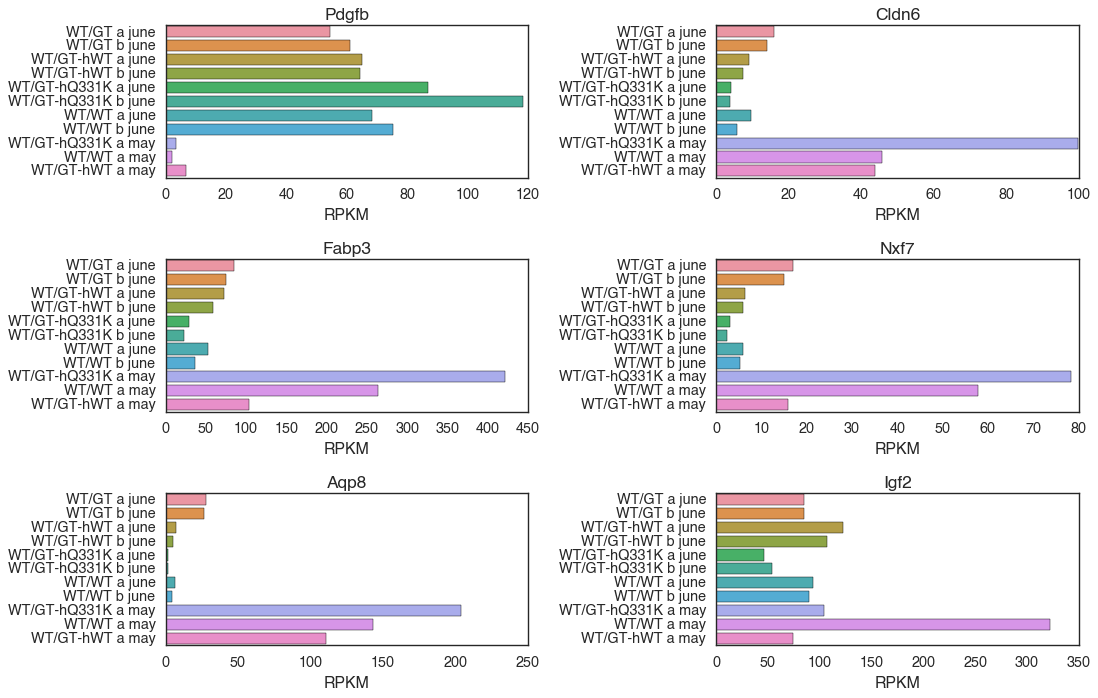

In [149]:
num_rows = 3
num_cols = 2

with dataviz.Figure(os.path.join(img_dir, "expression_reanalysis_of_important_genes.svg"), figsize=(7.0 * num_cols,3.0*num_rows)) as fig:
    for x, gene in enumerate(filtered_df.columns):        
        ax = fig.add_subplot(num_rows, num_cols,x + 1)
        sns.barplot(y=sample_names, x=filtered_df[gene].values, ax=ax)
        ax.set_title(ensembl_id_to_name[gene])
        ax.set_xlabel("RPKM")

In [ ]:
#check out GAPDH / Actin?

Pdgfb is up in Q331K mutant relative to everything else, not up in may experiments relative to the GT-hWT
Cldn6 down in Q331K mutants relative to everything else in June, reversed in May experiments
Fabp3 down in Q331K mutants relative to everything else in June, reversed in May experiments
Nxf7 down in Q331K mutants relative to everything else in June, reversed in May experiments
Apq8 down in Q331K mutants relative to everything else in June, reversed in May experiments
Igf2 is down in mutant relative to everything else, but down relative to WT/WT, but not GT-hWT in May experiments 

In [11]:
count_df[count_df.columns[5:]].to_csv("/home/gpratt/Dropbox/cryptic_splicing/data/mouse_data/important_counts.csv")

In [12]:
all_splicing_events = pd.read_csv("/projects/ps-yeolab3/from_hotel_node/for_anthony/analysis/av_mouse_stress_v2/combined_output/miso_summary_filtered.csv", index_col=[-2, 2, -1])

In [13]:
all_splicing_events.groupby(level=["sample_id", "splice_type"]).count().miso_posterior_mean.unstack()

splice_type                        A3SS  A5SS   MXE    RI     SE
sample_id                                                       
AV_cont_gt_a_S8_L007_R1_001        3789  2301   996  2477   9394
AV_cont_gt_b_S9_L007_R1_001        3869  2398  1001  2508   9638
AV_cont_hWT_A_S15_L008_R1_001      3763  2301  1005  2487   9368
AV_cont_hWT_b_S16_L008_R1_001      4129  2500  1076  2578  10022
AV_cont_q331k_A_S19_L008_R1_001    3833  2344  1010  2488   9476
AV_cont_q331k_b_S20_L008_R1_001    4006  2445  1040  2548   9815
AV_cont_rev_a_S12_L007_R1_001      3709  2307   981  2461   9275
AV_cont_rev_b_S13_L007_R1_001      3919  2406  1031  2531   9705
AV_q331k_S14_L007_R1_001           4201  2544  1059  2607  10140
AV_q331k_stress_S5_L006_R1_001     3886  2379  1002  2533   9459
AV_rev_S2_L006_R1_001              3872  2380   993  2535   9470
AV_rev_stress_S1_L006_R1_001       3683  2256   953  2472   8999
AV_stress_gt_a_S6_L006_R1_001      3862  2378  1008  2544   9554
AV_stress_gt_b_S7_L006_R1_001      3780  2382   980  2524   9420
AV_stress_hWT_A_S21_L008_R1_001    3500  2176   933  2423   8770
AV_stress_hWT_b_S22_L008_R1_001    3426  2126   913  2409   8551
AV_stress_q331K_A_S17_L008_R1_001  3431  2125   910  2377   8643
AV_stress_q331K_b_S18_L008_R1_001  3420  2118   902  1124   8537
AV_stress_rev_a_S10_L007_R1_001    3355  2102   909  2383   8387
AV_stress_rev_b_S11_L007_R1_001    3469  2178   929  2417   8719
AV_wt_S4_L006_R1_001               3827  2364   994  2522   9340
AV_wt_stress_S3_L006_R1_001        3836  2338  1005  2541   9359

In [14]:
all_splicing_events = pd.read_csv("/projects/ps-yeolab3/from_hotel_node/for_anthony/analysis/av_mouse_stress_v3/combined_output/miso_summary_filtered.csv", index_col=[-2, 2])
se_splicing_events = all_splicing_events[all_splicing_events.splice_type == "SE"]
se_splicing_events['total_counts'] = se_splicing_events.counts.apply(lambda x: pd.Series(dict([item.split("):") for item in x.split(",(")])).astype(float).sum())
se_splicing_events['total_assigned_counts'] = se_splicing_events.assigned_counts.apply(lambda x: pd.Series(dict([item.split(":") for item in x.split(",")])).astype(int).sum())
splicing_df = se_splicing_events.groupby(level=["sample_id", "event_name"]).first().miso_posterior_mean.unstack().fillna(.5)

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
se_splicing_matrix = se_splicing_events.groupby(level=["sample_id", "event_name"]).first().miso_posterior_mean.unstack()
se_splicing_matrix = se_splicing_matrix.T.ix[se_splicing_matrix.count() > 18].T.fillna(.5)

In [16]:
metadata = pd.DataFrame(index=splicing_df.index)
metadata['cell_type'] = "Mouse NPCs"
metadata['exp'] = ["_".join(item.split("_")[:-4]) for item in metadata.index]
metadata['stress'] = [True if "stress" in item else False for item in metadata.index]
metadata['phenotype'] = ["_".join(item.split("_")[:-4]) for item in metadata.index]
metadata['rep'] = [item.split("_")[3].lower() for item in metadata.index]
metadata['outlier'] = False
metadata['date'] = ["june" if ((item == "a") or (item == 'b')) else "may" for item in metadata.rep]
metadata.rep[~((metadata.rep == "a") | (metadata.rep == 'b'))] = 'a'

genotypes = ['gt', 'hWT', 'q331k', 'rev', 'wt']
result = []
for item in metadata.index:
    for genotype in genotypes:
        if genotype.lower() in item.lower():
            if genotype == 'wt':
                genotype = 'hWT'
            result.append(genotype)
            break
metadata['genotype'] = result
metadata['sample_id'] = metadata.index 

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
metadata.to_csv("/home/gpratt/Dropbox/cryptic_splicing/data/mouse_data/SampleInfo.csv")

In [18]:
mn_study_stress = flotilla.Study(# The metadata describing phenotype and pooled samples
                       metadata,
                       # A version for this data
                       version='0.1.0',
                       expression_data = flotilla_rpkm_df[metadata.date == "june"],
                       # Dataframe of the splicing data
                       splicing_data=splicing_df[metadata.date == "june"],
                       expression_thresh = 1,
                       species="mm10"
)

No phenotype to color mapping was provided, falling back on reasonable defaults.
No phenotype to marker (matplotlib plotting symbol) was provided, falling back on reasonable defaults.


2017-03-03 15:36:38 	Initializing Study
2017-03-03 15:36:38 	Initializing Predictor configuration manager for Study
2017-03-03 15:36:38	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2017-03-03 15:36:38	Added ExtraTreesClassifier to default predictors
2017-03-03 15:36:38	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2017-03-03 15:36:38	Added ExtraTreesRegressor to default predictors
2017-03-03 15:36:38	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2017-03-03 15:36:38	Added GradientBoostingClassifier to default predictors
2017-03-03 15:36:38	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
2017-03-03 15:36:38	Added GradientBoostingRegressor to default predictors
2017-03-03 15:36:38 	Loading metadata
2017-03-03 15:36:38	Loading species metadata from 

Error loading species mm10 data: HTTP Error 404: Not Found

2017-03-03 15:36:40	Loading expression data
2017-03-03 15:36:40	Initializing expression
2017-03-03 15:36:41	Done initializing expression
2017-03-03 15:36:41	Loading splicing data
2017-03-03 15:36:41	Initializing splicing
2017-03-03 15:36:41	Done initializing splicing
2017-03-03 15:36:41	Successfully initialized a Study object!


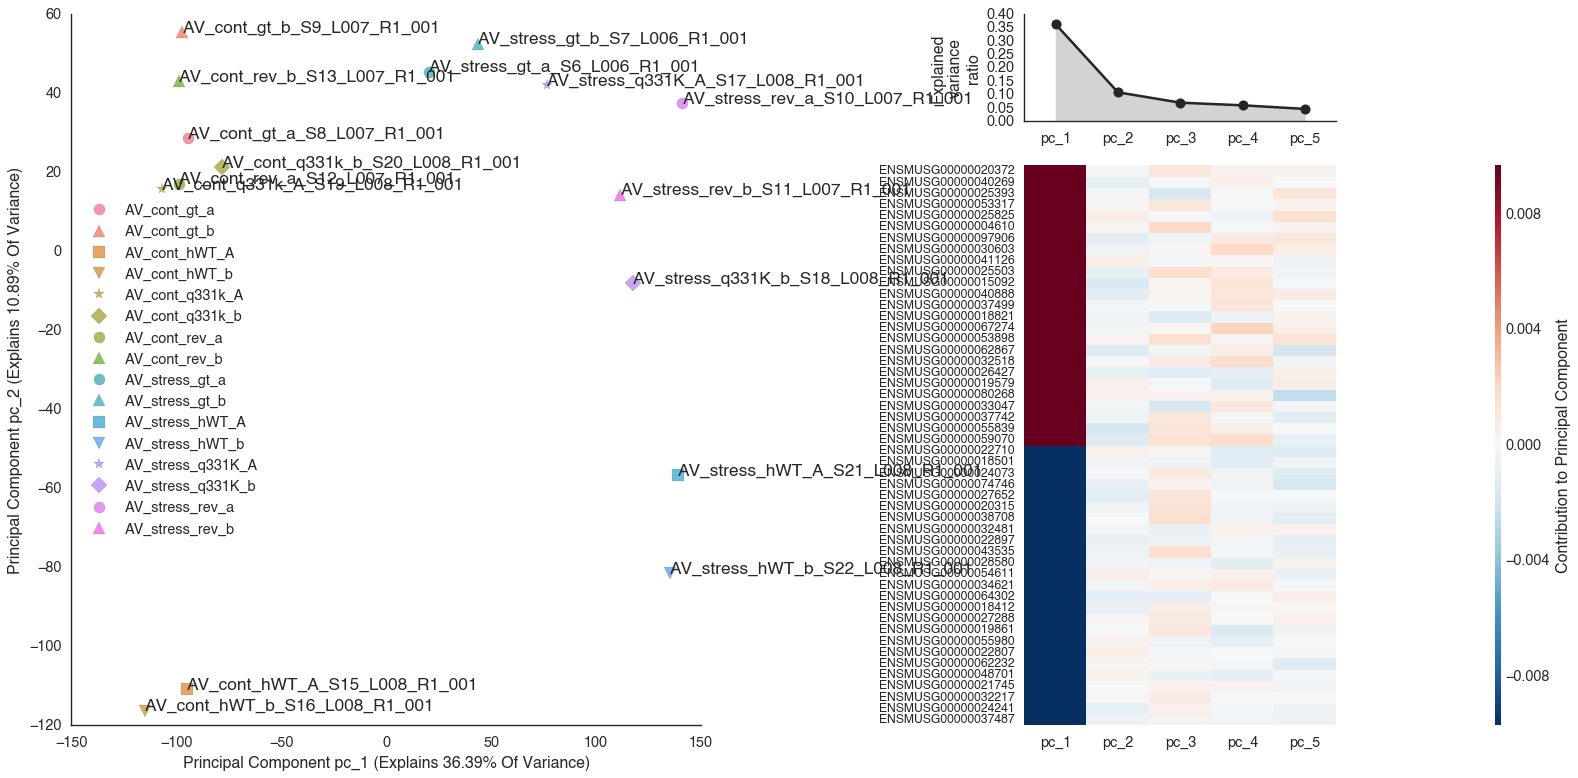

In [19]:
mn_study_stress.plot_pca(feature_subset="all", show_vectors=False, show_point_labels=True)
pyplot.savefig(os.path.join(img_dir, "expression_pca.pdf"))
pyplot.savefig(os.path.join(img_dir, "expression_pca.svg"))

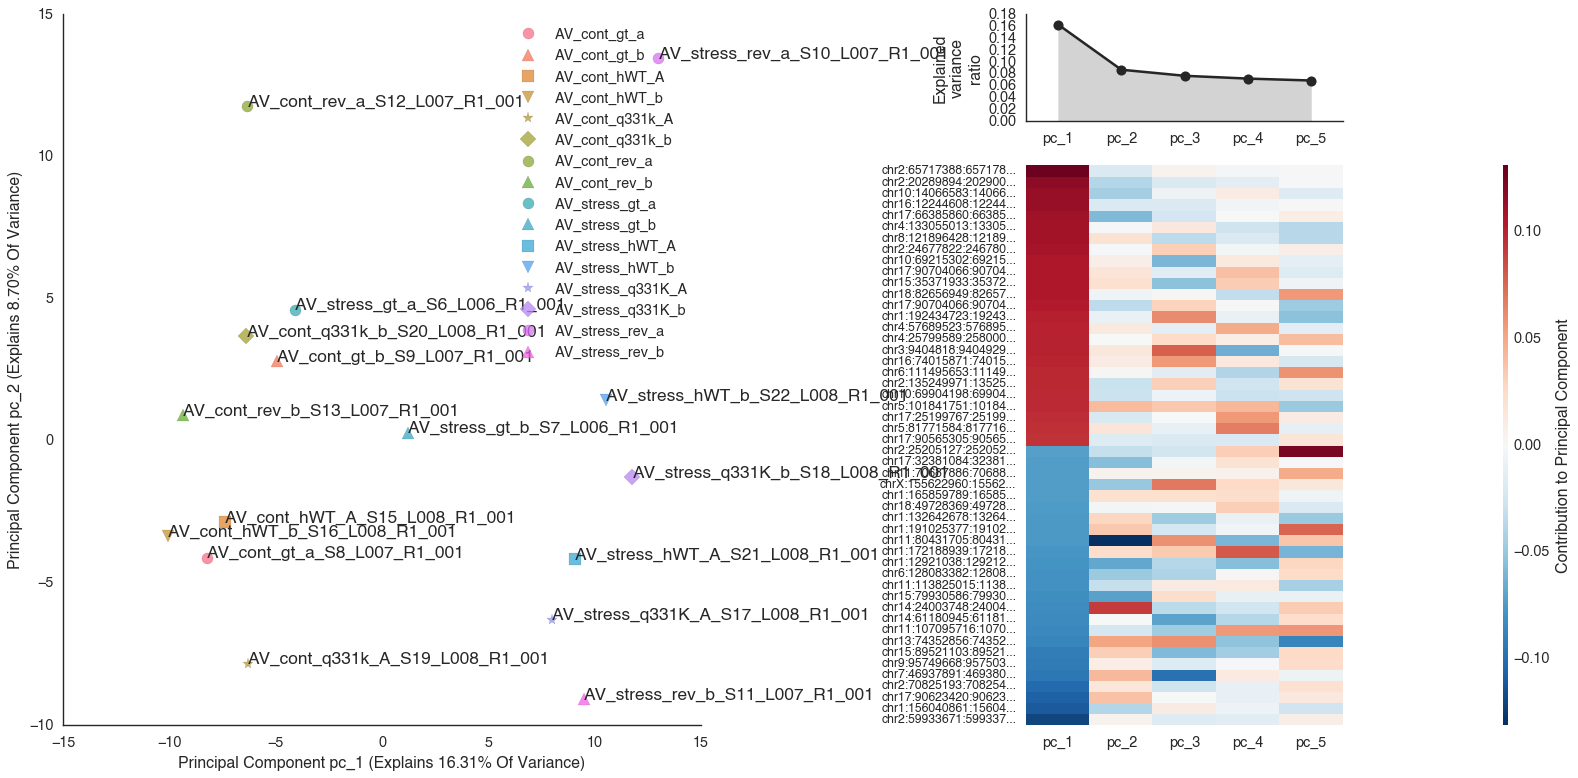

In [20]:
mn_study_stress.plot_pca(data_type="splicing", show_point_labels=True, show_vectors=False,)
pyplot.savefig(os.path.join(img_dir, "splicing_pca.pdf"))
pyplot.savefig(os.path.join(img_dir, "splicing_pca.svg"))

In [21]:
mn_study_unstressed = flotilla.Study(# The metadata describing phenotype and pooled samples
                       metadata,
                       # A version for this data
                       version='0.1.0',
                       expression_data = flotilla_rpkm_df[(metadata.date == "june") & ~metadata.stress],
                       # Dataframe of the splicing data
                       splicing_data=se_splicing_matrix[(metadata.date == "june") & ~metadata.stress],
                       expression_thresh = 1,
                       species="mm10"
)

2017-03-03 15:43:08 	Initializing Study
2017-03-03 15:43:08 	Initializing Predictor configuration manager for Study
2017-03-03 15:43:08	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2017-03-03 15:43:08	Added ExtraTreesClassifier to default predictors
2017-03-03 15:43:08	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2017-03-03 15:43:08	Added ExtraTreesRegressor to default predictors
2017-03-03 15:43:08	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2017-03-03 15:43:08	Added GradientBoostingClassifier to default predictors
2017-03-03 15:43:08	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
2017-03-03 15:43:08	Added GradientBoostingRegressor to default predictors
2017-03-03 15:43:08 	Loading metadata
2017-03-03 15:43:08	Loading species metadata from 

No phenotype to color mapping was provided, falling back on reasonable defaults.
No phenotype to marker (matplotlib plotting symbol) was provided, falling back on reasonable defaults.


https://s3-us-west-2.amazonaws.com/flotilla-projects/ercc/ERCC_Controls.txt has not been downloaded before.
2017-03-03 15:43:09	Loading expression data
2017-03-03 15:43:09	Initializing expression
2017-03-03 15:43:09	Done initializing expression


Error loading species mm10 data: HTTP Error 404: Not Found

2017-03-03 15:43:10	Loading splicing data
2017-03-03 15:43:10	Initializing splicing
2017-03-03 15:43:10	Done initializing splicing
2017-03-03 15:43:10	Successfully initialized a Study object!


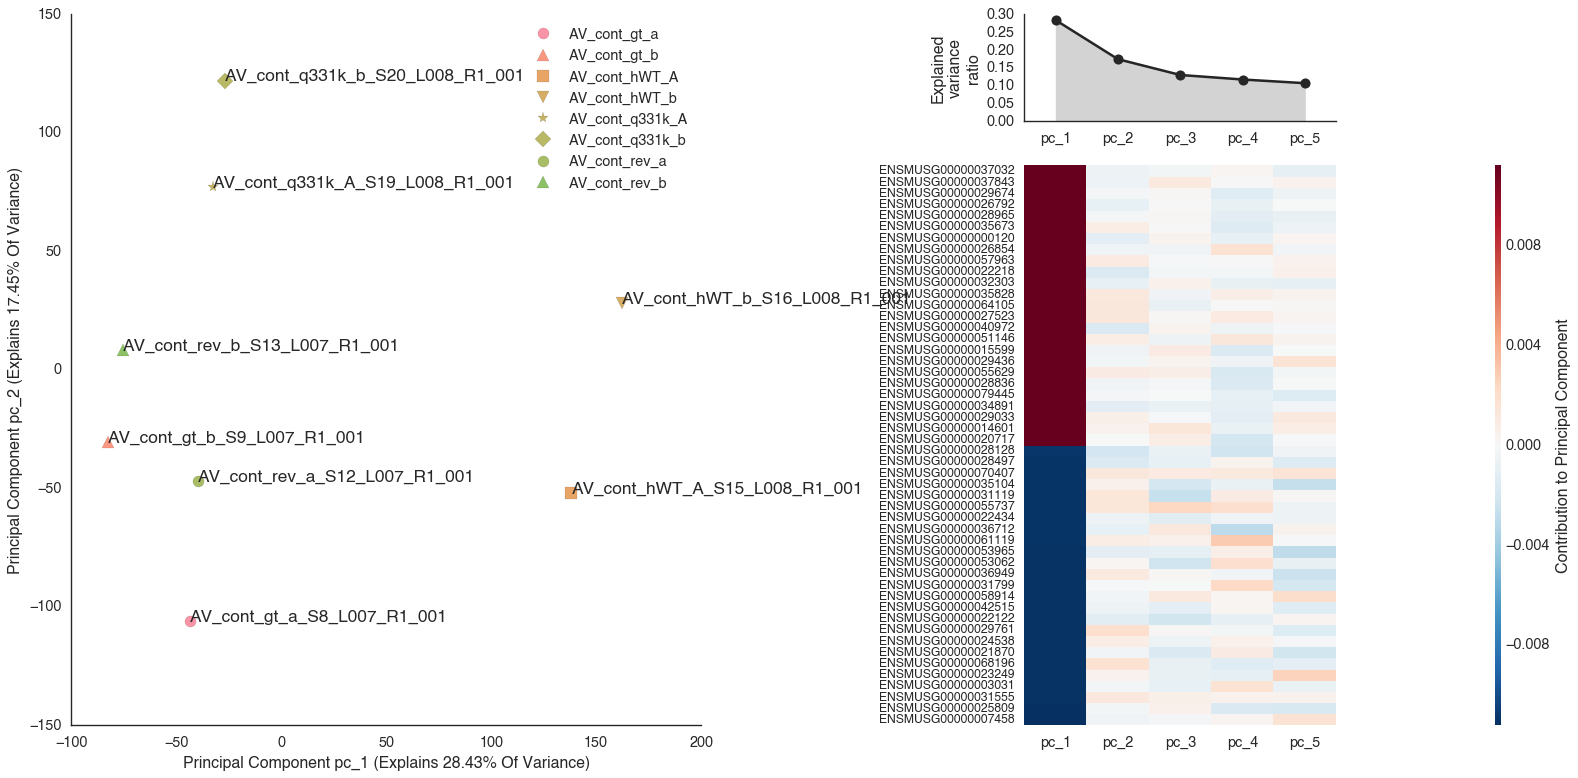

In [22]:
unstressed_pca = mn_study_unstressed.plot_pca(feature_subset="all", 
                             show_vectors=False, 
                             show_point_labels=True,
                             most_variant_features=False)
pyplot.savefig(os.path.join(img_dir, "unstressed_expression_pca.pdf"))
pyplot.savefig(os.path.join(img_dir, "unstressed_expression_pca.svg"))

In [154]:
mn_study_unstressed.plot_pca?

In [155]:
metadata.head()

cell_type              exp stress  \
sample_id                                                             
AV_cont_gt_a_S8_L007_R1_001      Mouse NPCs     AV_cont_gt_a  False   
AV_cont_gt_b_S9_L007_R1_001      Mouse NPCs     AV_cont_gt_b  False   
AV_cont_hWT_A_S15_L008_R1_001    Mouse NPCs    AV_cont_hWT_A  False   
AV_cont_hWT_b_S16_L008_R1_001    Mouse NPCs    AV_cont_hWT_b  False   
AV_cont_q331k_A_S19_L008_R1_001  Mouse NPCs  AV_cont_q331k_A  False   

                                       phenotype rep outlier  date genotype  \
sample_id                                                                     
AV_cont_gt_a_S8_L007_R1_001         AV_cont_gt_a   a   False  june       gt   
AV_cont_gt_b_S9_L007_R1_001         AV_cont_gt_b   b   False  june       gt   
AV_cont_hWT_A_S15_L008_R1_001      AV_cont_hWT_A   a   False  june      hWT   
AV_cont_hWT_b_S16_L008_R1_001      AV_cont_hWT_b   b   False  june      hWT   
AV_cont_q331k_A_S19_L008_R1_001  AV_cont_q331k_A   a   False  june    q331k   

                                                       sample_id  
sample_id                                                         
AV_cont_gt_a_S8_L007_R1_001          AV_cont_gt_a_S8_L007_R1_001  
AV_cont_gt_b_S9_L007_R1_001          AV_cont_gt_b_S9_L007_R1_001  
AV_cont_hWT_A_S15_L008_R1_001      AV_cont_hWT_A_S15_L008_R1_001  
AV_cont_hWT_b_S16_L008_R1_001      AV_cont_hWT_b_S16_L008_R1_001  
AV_cont_q331k_A_S19_L008_R1_001  AV_cont_q331k_A_S19_L008_R1_001

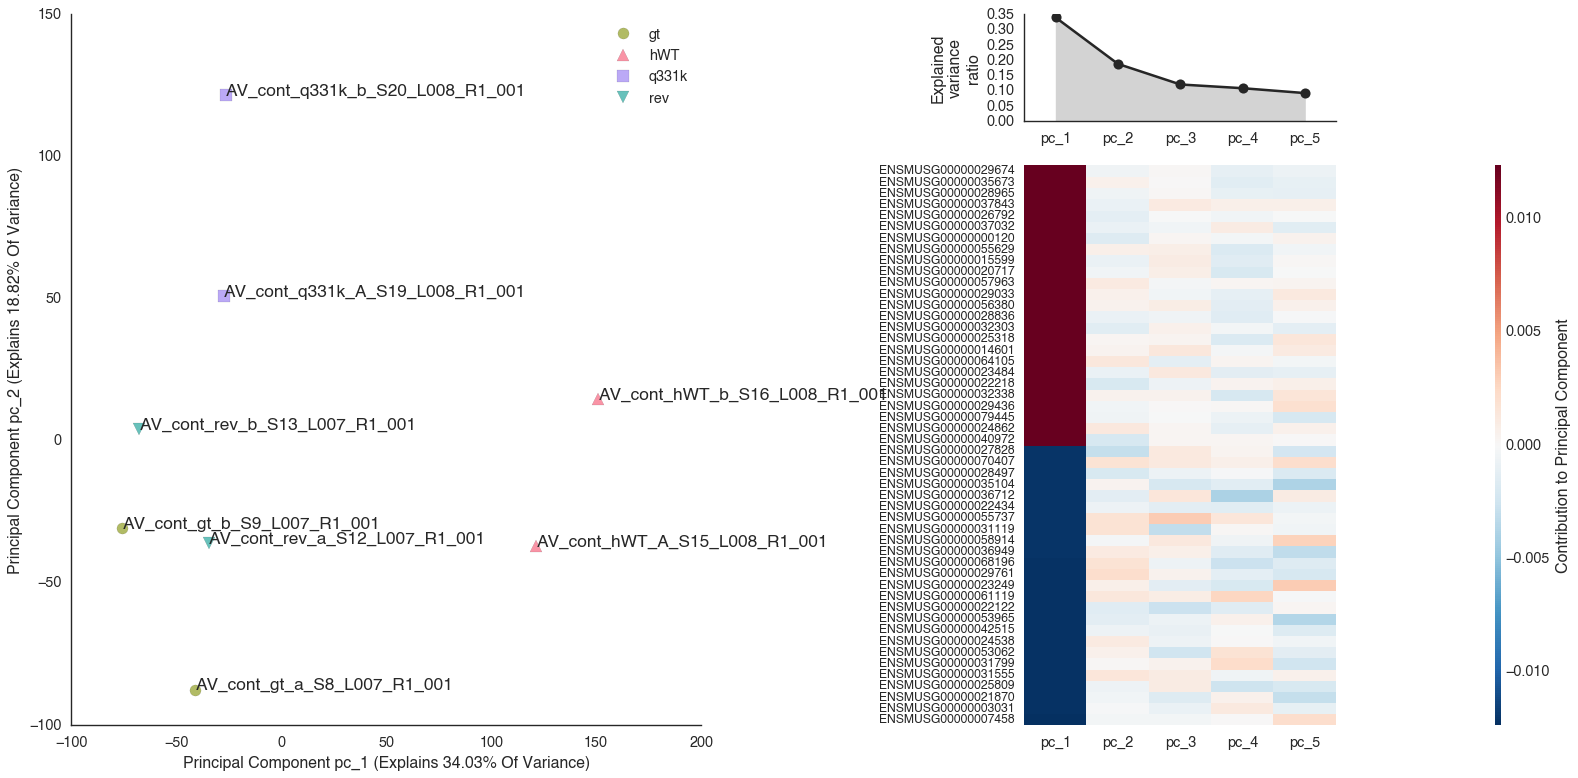

In [163]:
unstressed_protein_coding_pca = mn_study_unstressed.plot_pca(feature_subset="gene_type: protein_coding", 
                                                             show_vectors=False, 
                                                             show_point_labels=True,
                                                             most_variant_features=False,
                                                             color_samples_by="genotype")

pyplot.savefig(os.path.join(img_dir, "unstressed_expression_protein_coding_pca.pdf"))
pyplot.savefig(os.path.join(img_dir, "unstressed_expression_protein_coding_pca.svg"))

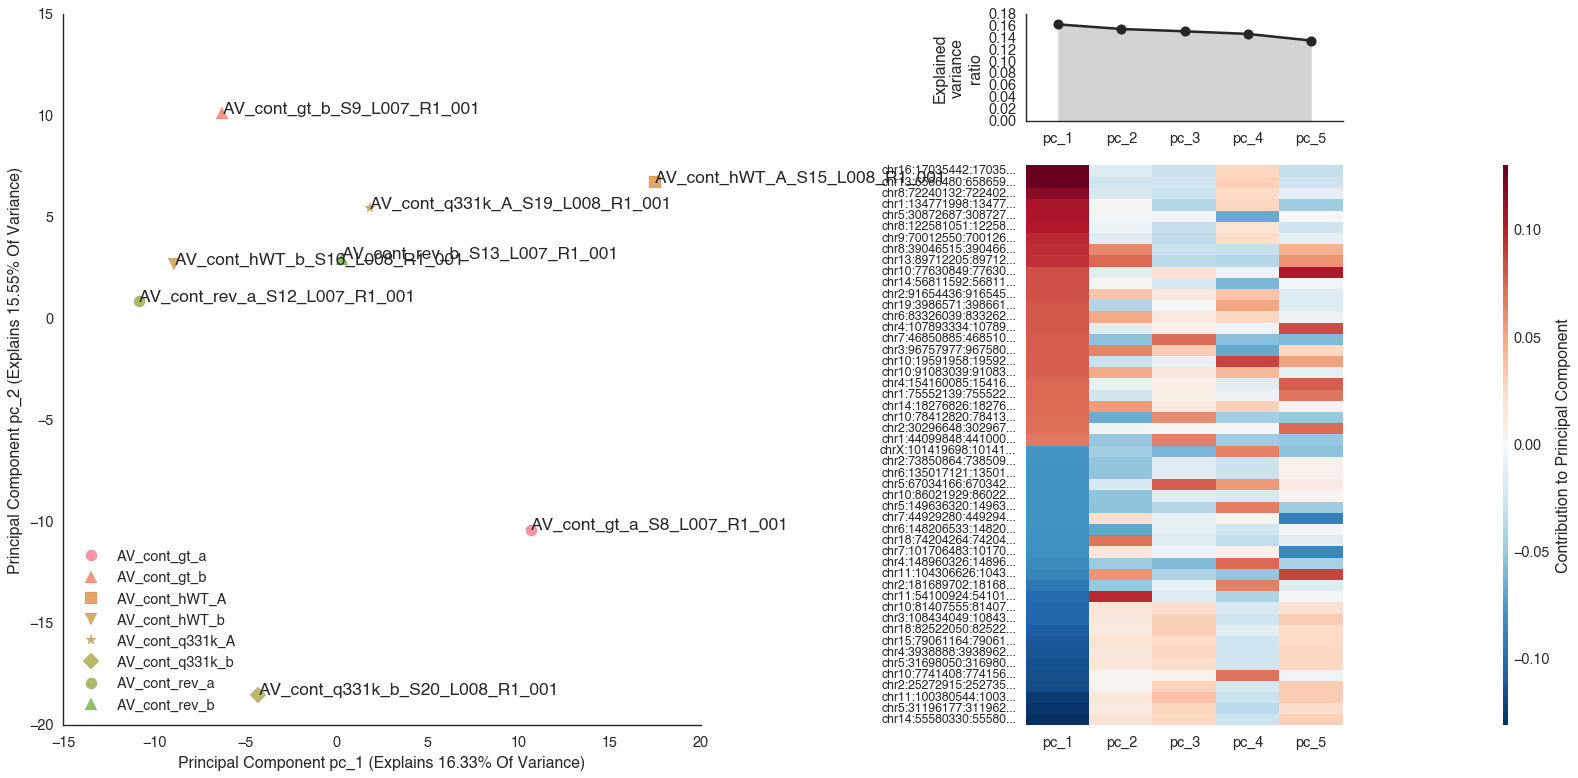

In [24]:
unstressed_protein_coding_splicing_pca = mn_study_unstressed.plot_pca(#feature_subset="gene_type: protein_coding", 
                                                             data_type="splicing",
    show_vectors=False, 
                             show_point_labels=True,
                             most_variant_features=False)
pyplot.savefig(os.path.join(img_dir, "unstressed_splicing_protein_coding_pca.pdf"))
pyplot.savefig(os.path.join(img_dir, "unstressed_splicing_protein_coding_pca.svg"))

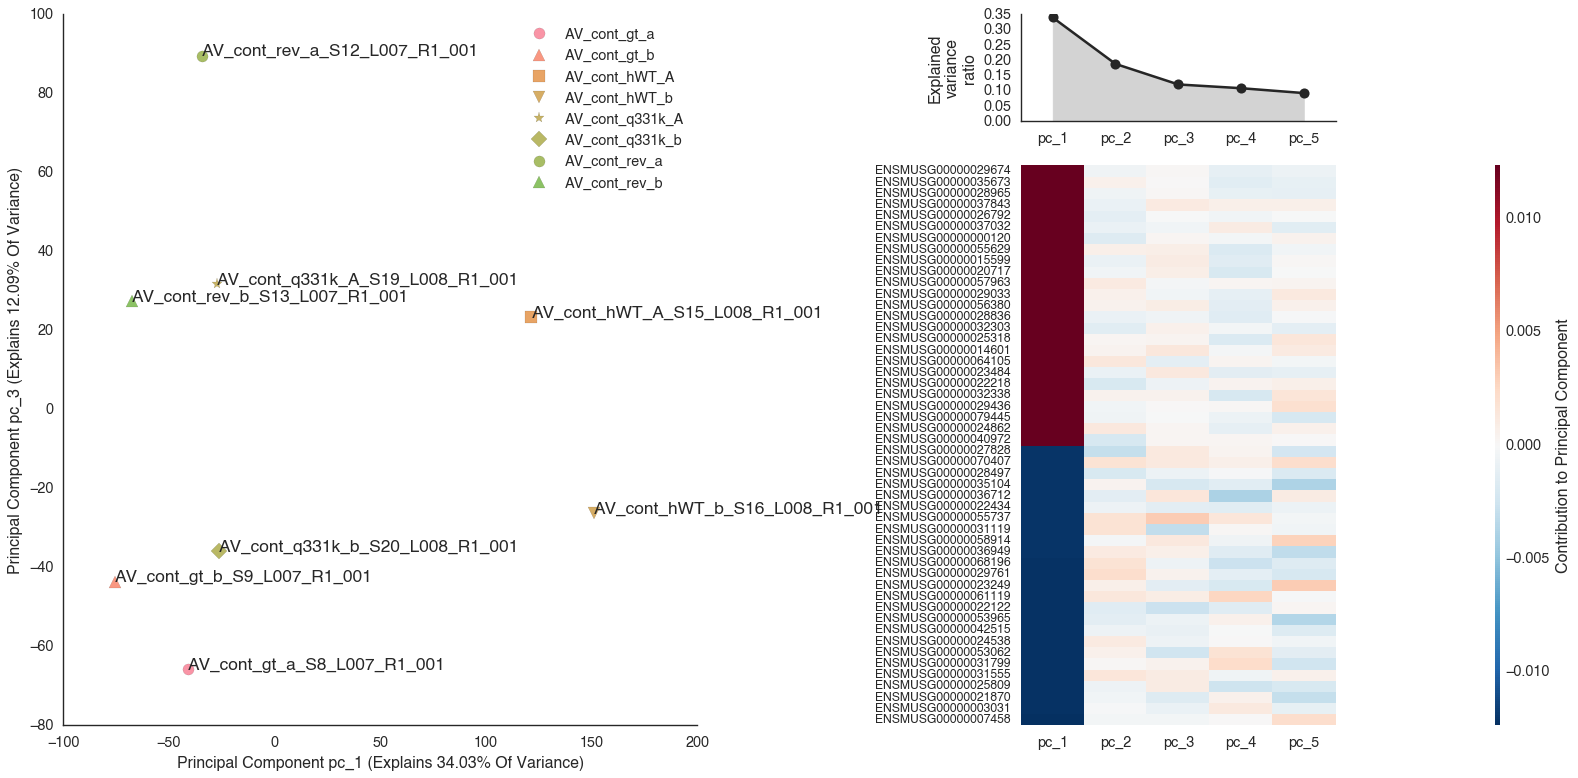

In [25]:
mn_study_unstressed.plot_pca(feature_subset="gene_type: protein_coding", 
                             show_vectors=False, 
                             show_point_labels=True,
                             most_variant_features=False,
                                                            x_pc=1,
                                                            y_pc=3)
pyplot.savefig(os.path.join(img_dir, "unstressed_expression_protein_coding_pca_pc_1-3.pdf"))
pyplot.savefig(os.path.join(img_dir, "unstressed_expression_protein_coding_pca_pc_1-3.svg"))

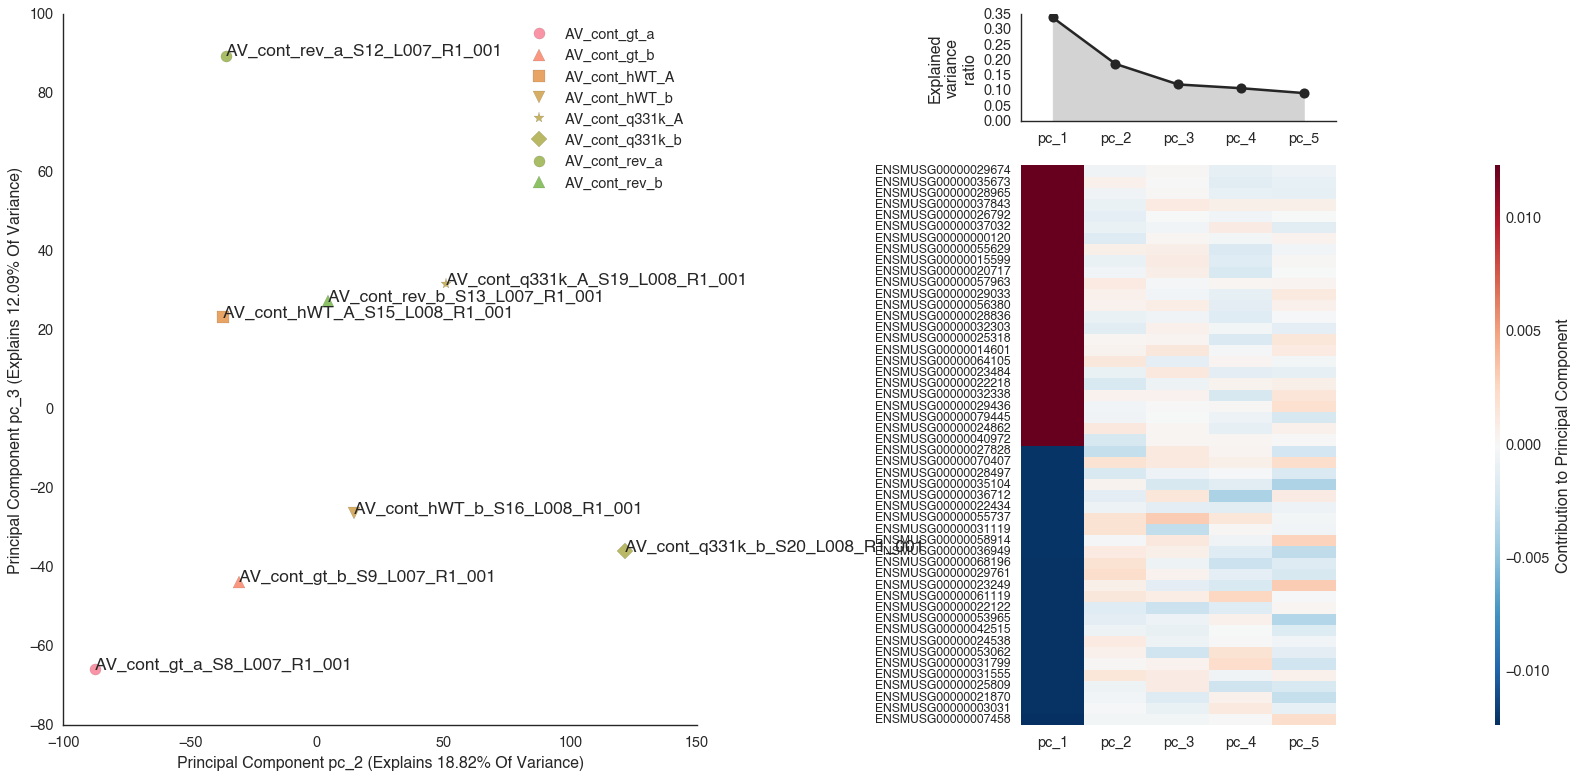

In [26]:
mn_study_unstressed.plot_pca(feature_subset="gene_type: protein_coding", 
                             show_vectors=False, 
                             show_point_labels=True,
                             most_variant_features=False,
                                                            x_pc=2,
                                                            y_pc=3)
pyplot.savefig(os.path.join(img_dir, "unstressed_expression_protein_coding_pca_pc_2-3.pdf"))
pyplot.savefig(os.path.join(img_dir, "unstressed_expression_protein_coding_pca_pc_2-3.svg"))

In [27]:
#unstressed_protein_coding_pca.components_.columns = [ensembl_id_to_name[item] for item in unstressed_protein_coding_pca.components_]

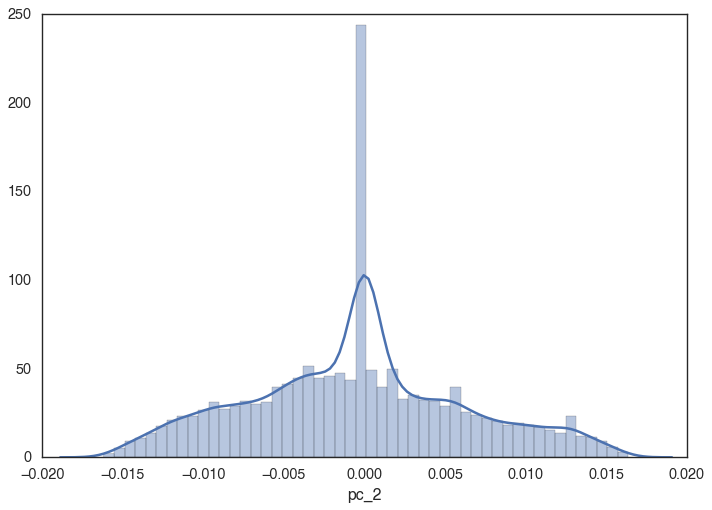

In [28]:
sns.distplot(unstressed_protein_coding_pca.components_.ix['pc_2'].sort_values())

In [29]:
mn_study_stressed = flotilla.Study(# The metadata describing phenotype and pooled samples
                       metadata,
                       # A version for this data
                       version='0.1.0',
                       expression_data = flotilla_rpkm_df[(metadata.date == "june") & metadata.stress ],
                       # Dataframe of the splicing data
                       splicing_data=splicing_df[(metadata.date == "june") & metadata.stress],
                       expression_thresh = 1,
                       species="mm10"
)

2017-03-03 15:44:05 	Initializing Study
2017-03-03 15:44:05 	Initializing Predictor configuration manager for Study
2017-03-03 15:44:05	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2017-03-03 15:44:05	Added ExtraTreesClassifier to default predictors
2017-03-03 15:44:05	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2017-03-03 15:44:05	Added ExtraTreesRegressor to default predictors
2017-03-03 15:44:05	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2017-03-03 15:44:05	Added GradientBoostingClassifier to default predictors
2017-03-03 15:44:05	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
2017-03-03 15:44:05	Added GradientBoostingRegressor to default predictors
2017-03-03 15:44:05 	Loading metadata
2017-03-03 15:44:05	Loading species metadata from 

No phenotype to color mapping was provided, falling back on reasonable defaults.
No phenotype to marker (matplotlib plotting symbol) was provided, falling back on reasonable defaults.


https://s3-us-west-2.amazonaws.com/flotilla-projects/ercc/ERCC_Controls.txt has not been downloaded before.
2017-03-03 15:44:06	Loading expression data
2017-03-03 15:44:06	Initializing expression
2017-03-03 15:44:06	Done initializing expression


Error loading species mm10 data: HTTP Error 404: Not Found

2017-03-03 15:44:07	Loading splicing data
2017-03-03 15:44:07	Initializing splicing
2017-03-03 15:44:07	Done initializing splicing
2017-03-03 15:44:07	Successfully initialized a Study object!


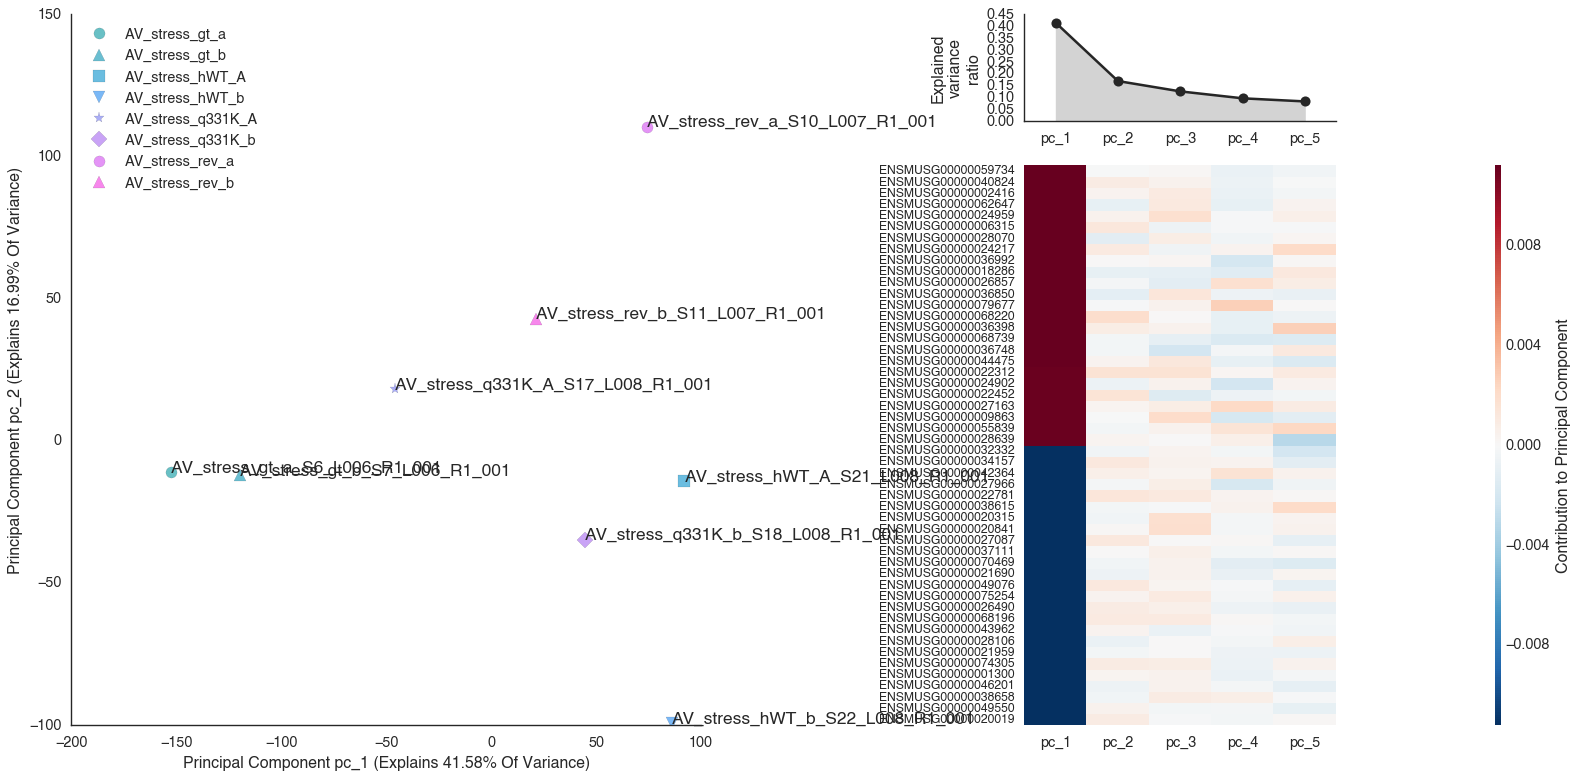

In [30]:
mn_study_stressed.plot_pca(feature_subset="gene_type: protein_coding", 
                             show_vectors=False, 
                             show_point_labels=True,
                             most_variant_features=False)
pyplot.savefig(os.path.join(img_dir, "stressed_expression_pca.pdf"))
pyplot.savefig(os.path.join(img_dir, "stressed_expression_pca.svg"))

In [158]:
mn_study_stressed.plot_pca?

In [159]:
mn_study_stressed.plot_pca?

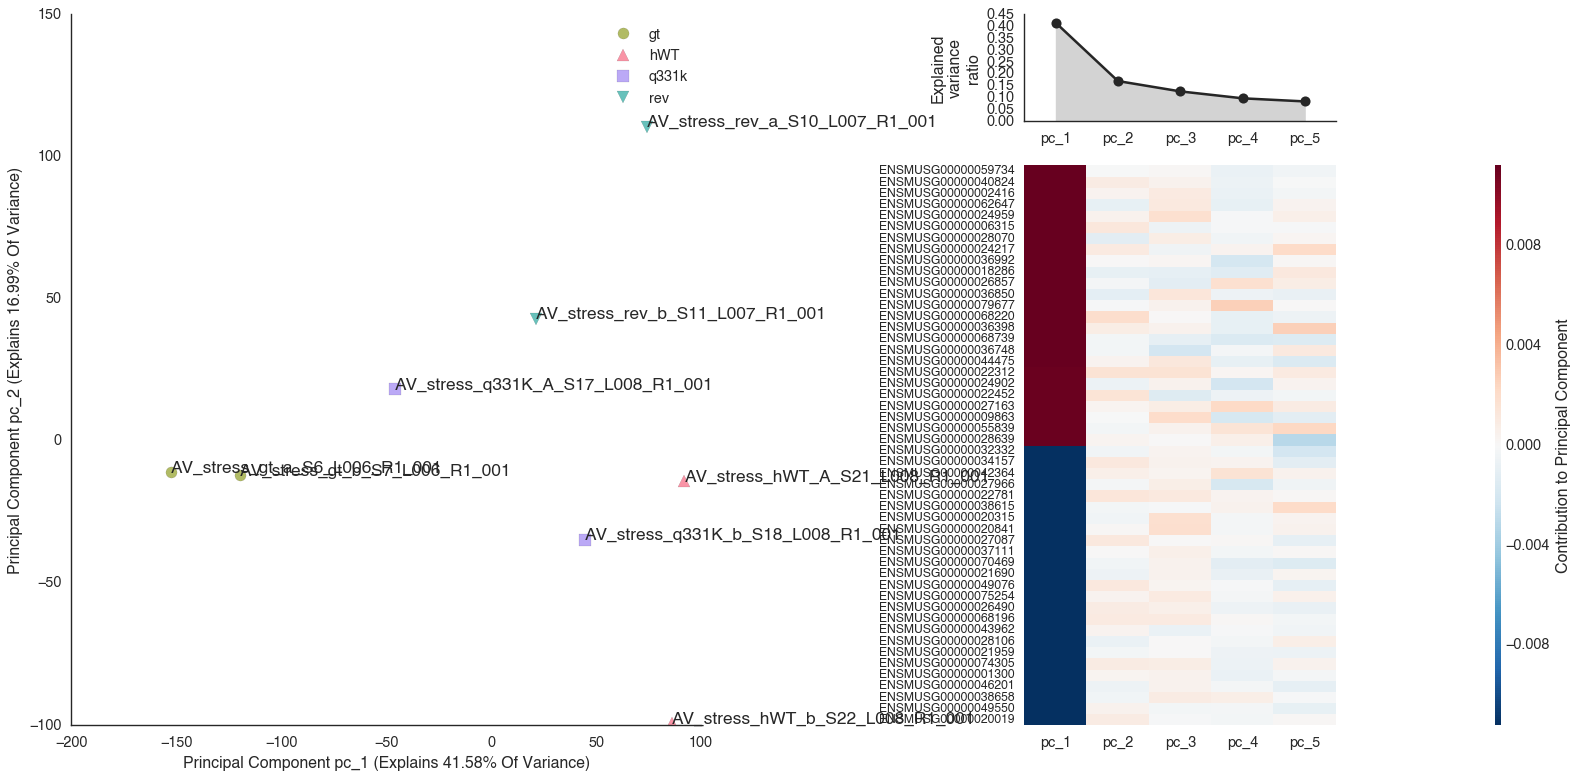

In [162]:
mn_study_stressed.plot_pca(feature_subset="gene_type: protein_coding", 
                           show_vectors=False, 
                           show_point_labels=True,
                           most_variant_features=False,
                           color_samples_by="genotype",
                          )
pyplot.savefig(os.path.join(img_dir, "stressed_expression_protein_coding_pca.pdf"))
pyplot.savefig(os.path.join(img_dir, "stressed_expression_protein_coding_pca.svg"))

# Look at Reproducablity between replicates

In [32]:
rpkm_df.index = pd.MultiIndex.from_arrays(np.array(metadata.T), names=metadata.columns)

In [33]:
r2_matrix = defaultdict(dict)
for y, (name1, name2) in enumerate(itertools.permutations(rpkm_df.index, 2)):
    series1 = rpkm_df.ix[name1]
    series2 = rpkm_df.ix[name2]
    r2_matrix[name1][name2] = scipy.stats.linregress(series1, series2)[2]
r2_matrix = pd.DataFrame(r2_matrix)
r2_matrix = r2_matrix.fillna(1)

In [34]:
#r2_matrix.index = ["_".join(item[:-4]) for item in  r2_matrix.index]
#r2_matrix.columns = ["_".join(item[:-4]) for item in  r2_matrix.columns]

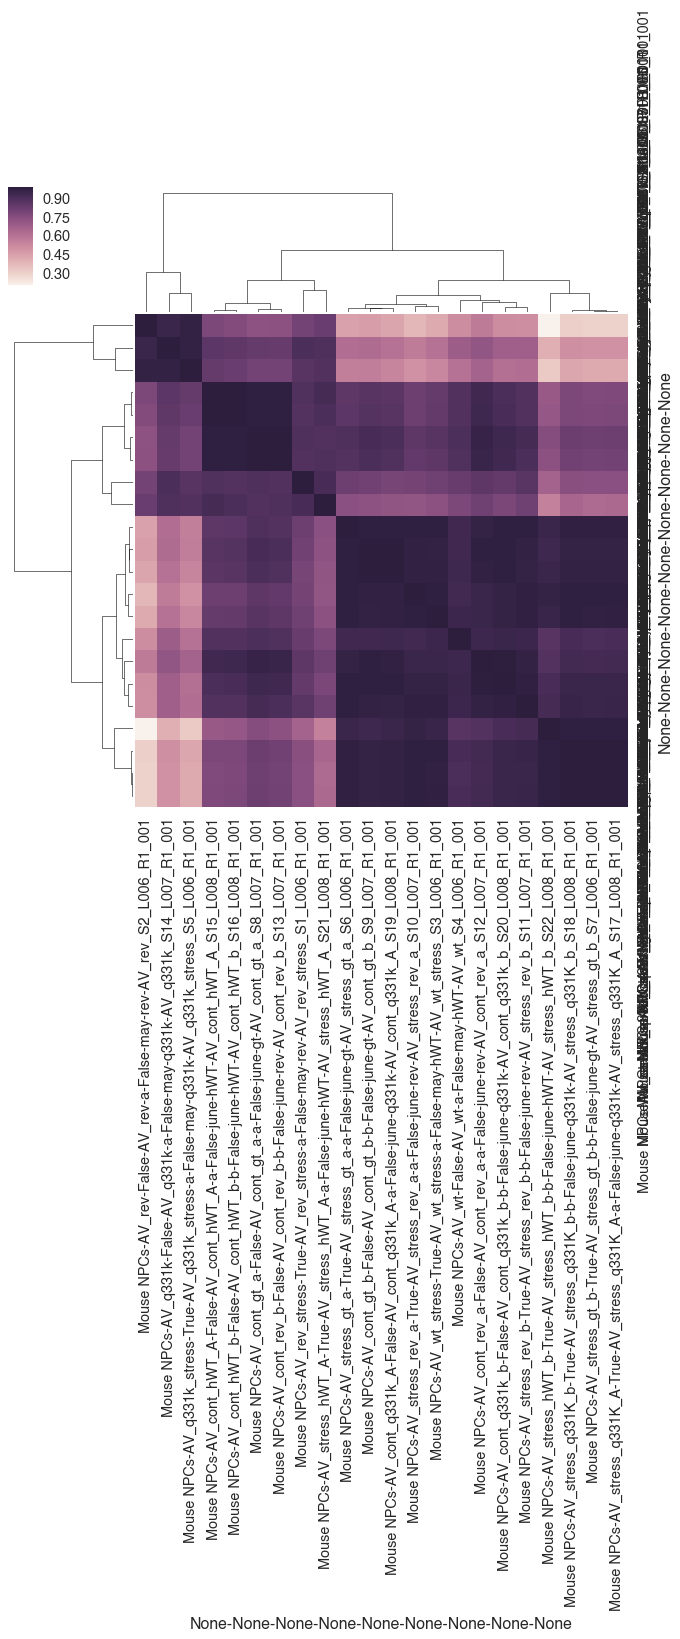

In [35]:
sns.clustermap(r2_matrix)
pyplot.savefig(os.path.join(img_dir, "correlation_clustergram.svg"))
pyplot.savefig(os.path.join(img_dir, "correlation_clustergram.pdf"))

8 3


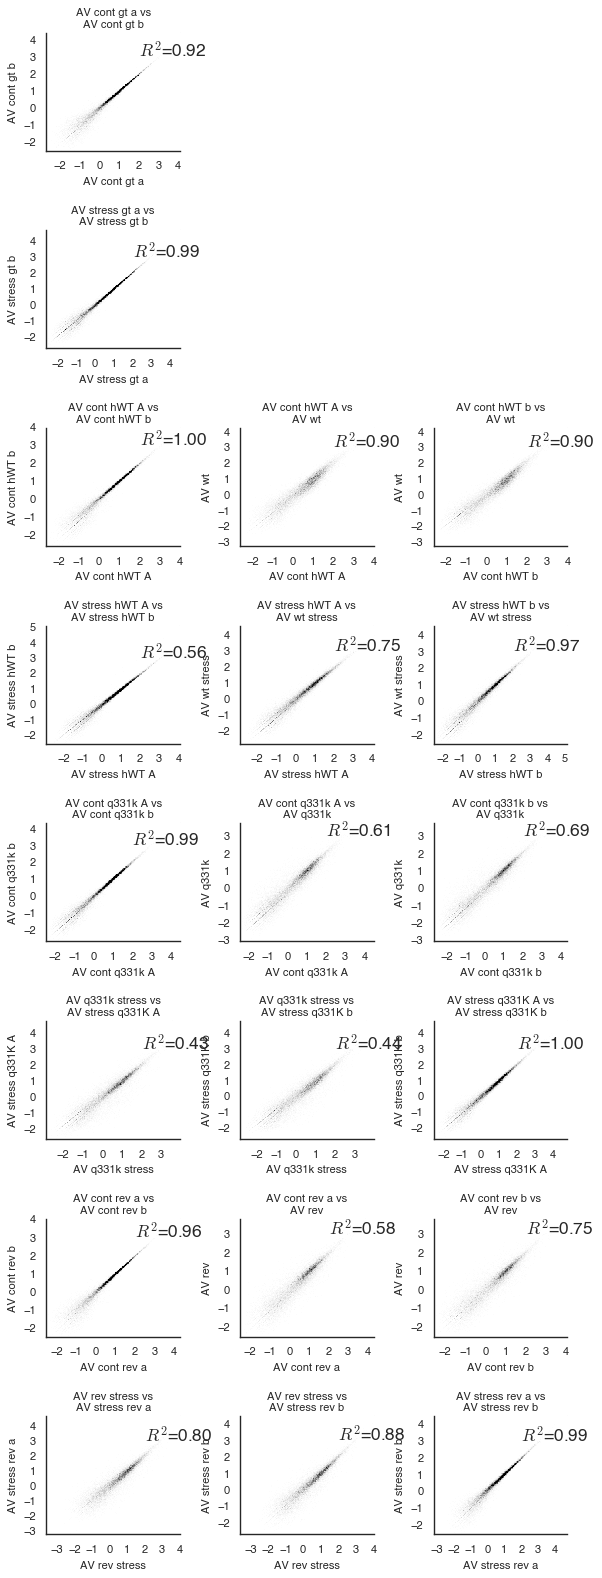

In [36]:
max_combinations = np.max(rpkm_df.groupby(level=["genotype", 'stress']).count().values)
num_rows = len(list(rpkm_df.groupby(level=["genotype", 'stress'])))
num_cols = len(list(itertools.combinations(range(max_combinations), 2)))
print num_rows, num_cols 
with dataviz.Figure(os.path.join(img_dir, "replicate_plotting.svg"), figsize=(2.5 * num_cols,2.5*num_rows)) as fig:
    gs = gridspec.GridSpec(num_rows, num_cols)
    for x, (name, group) in enumerate(rpkm_df.groupby(level=["genotype", 'stress'])):
        for y, (name1, name2) in enumerate(itertools.combinations(group.index, 2)):
            ax = fig.add_subplot(gs[x,y])
            series1 = rpkm_df.ix[name1]
            series2 = rpkm_df.ix[name2]

            dataviz.loglog_hist2d(series1, series2, ax=ax)
            sns.despine(ax=ax)
            name1 = " ".join(map(str, name1[-1].split("_")[:-4]))
            name2 = " ".join(map(str, name2[-1].split("_")[:-4]))
            
            ax.set_xlabel(name1, fontsize=10)
            ax.set_ylabel(name2, fontsize=10)
            r2 = scipy.stats.linregress(series1, series2)[2]
            ax.text(2, 3, "$R^2$={:.2f}".format(r2))
            ax.set_title("{} vs\n{}".format(name1, name2), fontsize=10)
            [tick.set_fontsize(10) for tick in ax.get_xticklabels()]
            [tick.set_fontsize(10) for tick in ax.get_yticklabels()]

# look at reproducablity between stress vs un-stress conditions

4 9


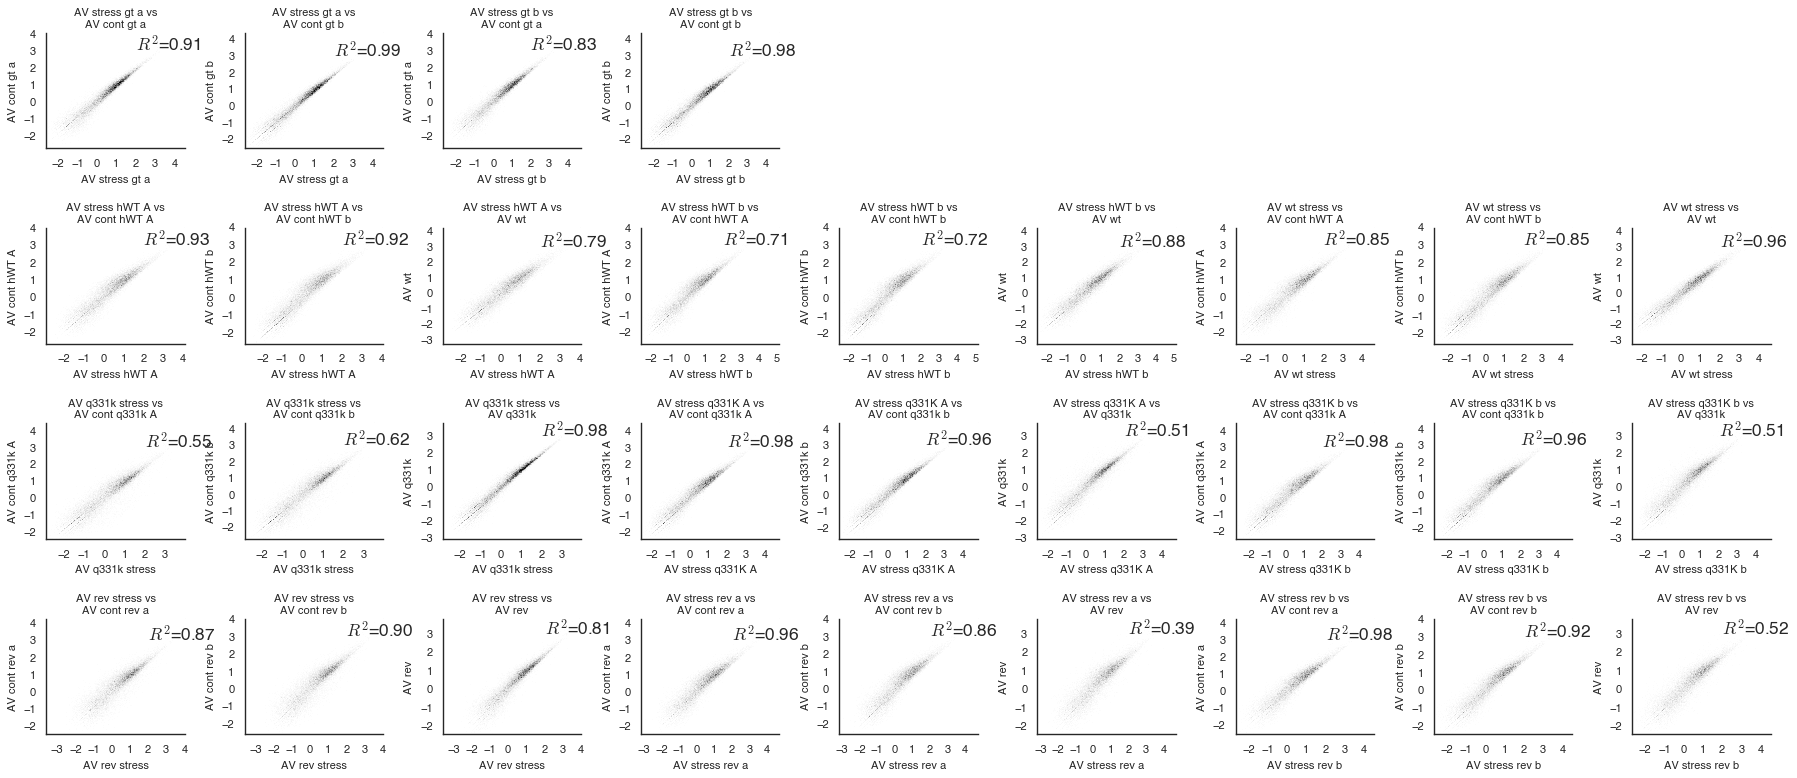

In [37]:
max_combinations = np.max(rpkm_df.groupby(level=["genotype"]).count().values)
num_rows = len(list(rpkm_df.groupby(level=["genotype"])))
num_cols = 9 #len(list(itertools.combinations(range(max_combinations), 2)))
print num_rows, num_cols 
with dataviz.Figure(os.path.join(img_dir, "stress_plotting.svg"), figsize=(2.5 * num_cols,2.5*num_rows)) as fig:
    gs = gridspec.GridSpec(num_rows, num_cols)
    for x, (name, group) in enumerate(rpkm_df.groupby(level=["genotype"])): 
        for y, (name1, name2) in enumerate(itertools.product(group.xs(True, level="stress", drop_level=False).index, group.xs(False, level="stress", drop_level=False).index)):
            ax = fig.add_subplot(gs[x,y])
            series1 = group.ix[name1]
            series2 = group.ix[name2]

            dataviz.loglog_hist2d(series1, series2, ax=ax)
            sns.despine(ax=ax)
            name1 = " ".join(map(str, name1[-1].split("_")[:-4]))
            name2 = " ".join(map(str, name2[-1].split("_")[:-4]))
            
            ax.set_xlabel(name1, fontsize=10)
            ax.set_ylabel(name2, fontsize=10)
            r2 = scipy.stats.linregress(series1, series2)[2]
            ax.text(2, 3, "$R^2$={:.2f}".format(r2))
            ax.set_title("{} vs\n{}".format(name1, name2), fontsize=10)
            [tick.set_fontsize(10) for tick in ax.get_xticklabels()]
            [tick.set_fontsize(10) for tick in ax.get_yticklabels()]

# Lets do some descriptives on differentally expressed genes

In [38]:
stress_vs_unstress = pd.concat({os.path.basename(item).split("_")[0]: pd.read_csv(item, index_col=0) for item in glob.glob("/home/gpratt/Dropbox/cryptic_splicing/data/mouse_data/*stress.csv")}, names=["genotype", "gene_id"])
sig_stress_vs_unstress = stress_vs_unstress[(stress_vs_unstress.padj <= .05)  & (abs(stress_vs_unstress.log2FoldChange) > np.log2(1.5))]
sig_stress_vs_unstress_upregulated = sig_stress_vs_unstress[sig_stress_vs_unstress.log2FoldChange > 0]
sig_stress_vs_unstress_downregulated = sig_stress_vs_unstress[sig_stress_vs_unstress.log2FoldChange < 0]

In [39]:
pd.concat({"upregulated": sig_stress_vs_unstress_upregulated.groupby(level="genotype").count().baseMean,
           "downregulated": sig_stress_vs_unstress_downregulated.groupby(level="genotype").count().baseMean}).unstack()

genotype         gt   hWT  q331k   rev
downregulated  2651  4597   3849  4263
upregulated    1354  3712   2754  3269

/home/gpratt/anaconda/lib/python2.7/site-packages/matplotlib_venn-0.10-py2.7.egg/matplotlib_venn/_venn3.py:238: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
/home/gpratt/anaconda/lib/python2.7/site-packages/matplotlib_venn-0.10-py2.7.egg/matplotlib_venn/_venn3.py:239: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
/home/gpratt/anaconda/lib/python2.7/site-packages/matplotlib_venn-0.10-py2.7.egg/matplotlib_venn/_venn3.py:240: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
/home/gpratt/anaconda/lib/python2.7/site-packages/matplotlib_venn-0.10-py2.7.egg/matplotlib_venn/_venn3.py:241: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
/home/gpratt/anaconda/lib/python2.7/site-packages/matplotlib_venn-0.10-py2.7.egg/matplotlib_venn/_venn3.py:242: FutureWarning: using '-' to provide set differen

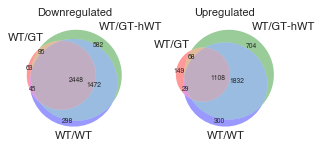

In [40]:
with dataviz.Figure(os.path.join(img_dir, "control_change.svg"), figsize=(4, 2)) as fig:
    ax = fig.add_subplot(1,2,1)
    venn = venn3([sig_stress_vs_unstress_downregulated.ix['gt'].index,
                  sig_stress_vs_unstress_downregulated.ix['hWT'].index,
                  sig_stress_vs_unstress_downregulated.ix['rev'].index,],
            set_labels=map(lambda x: names[x], ("gt", "hWT", "rev")), 
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(1,2,2)
    venn = venn3([sig_stress_vs_unstress_upregulated.ix['gt'].index,
                  sig_stress_vs_unstress_upregulated.ix['hWT'].index,
                  sig_stress_vs_unstress_upregulated.ix['rev'].index,],
            set_labels=map(lambda x: names[x], ("gt", "hWT", "rev")),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]

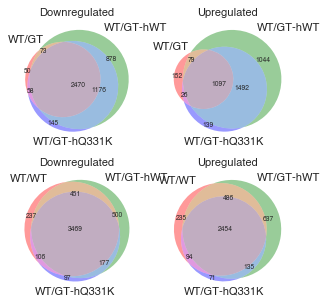

In [41]:
with dataviz.Figure(os.path.join(img_dir, "q311k_change.svg"), figsize=(4, 4)) as fig:
    ax = fig.add_subplot(2,2,1)
    venn = venn3([sig_stress_vs_unstress_downregulated.ix['gt'].index,
                  sig_stress_vs_unstress_downregulated.ix['hWT'].index,
                  sig_stress_vs_unstress_downregulated.ix['q331k'].index,],
            set_labels=map(lambda x: names[x], ("gt", "hWT", "q331k")), 
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(2,2,2)
    venn = venn3([sig_stress_vs_unstress_upregulated.ix['gt'].index,
                  sig_stress_vs_unstress_upregulated.ix['hWT'].index,
                  sig_stress_vs_unstress_upregulated.ix['q331k'].index,],
            set_labels=map(lambda x: names[x], ("gt", "hWT", "q331k")),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]
    
    ax = fig.add_subplot(2,2,3)
    venn = venn3([sig_stress_vs_unstress_downregulated.ix['rev'].index,
                  sig_stress_vs_unstress_downregulated.ix['hWT'].index,
                  sig_stress_vs_unstress_downregulated.ix['q331k'].index,],
            set_labels=map(lambda x: names[x], ("rev", "hWT", "q331k")), 
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(2,2,4)
    venn = venn3([sig_stress_vs_unstress_upregulated.ix['rev'].index,
                  sig_stress_vs_unstress_upregulated.ix['hWT'].index,
                  sig_stress_vs_unstress_upregulated.ix['q331k'].index,],
            set_labels=map(lambda x: names[x], ("rev", "hWT", "q331k")),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]

#How does Q331k Differ when directly compared to controls?

In [42]:
q331k_vs_ctrls = pd.concat({os.path.basename(item).split(".")[0]: pd.read_csv(item, index_col=0) for item in glob.glob("/home/gpratt/Dropbox/cryptic_splicing/data/mouse_data/*stressed.csv")}, names=["genotype", "gene_id"])
result = []
for (exp, gene_id) in q331k_vs_ctrls.index:
    result.append((exp.split("_")[2], exp.split("_")[3], gene_id))
q331k_vs_ctrls.index = pd.MultiIndex.from_tuples(result, names=['ctrl', 'stress', 'gene_id'])

In [43]:
sig_q331k_vs_ctrls = q331k_vs_ctrls[(q331k_vs_ctrls.padj <= .05)  & (abs(q331k_vs_ctrls.log2FoldChange) > np.log2(1.5))]
sig_q331k_vs_ctrls_upregulated = sig_q331k_vs_ctrls[sig_q331k_vs_ctrls.log2FoldChange > 0]
sig_q331k_vs_ctrls_downregulated = sig_q331k_vs_ctrls[sig_q331k_vs_ctrls.log2FoldChange < 0]

In [44]:
differental_expression = pd.concat({"upregulated": sig_q331k_vs_ctrls_upregulated.groupby(level=["ctrl", 'stress']).count().baseMean,
           "downregulated": sig_q331k_vs_ctrls_downregulated.groupby(level=["ctrl", 'stress']).count().baseMean})

In [45]:
differental_expression.swaplevel(0,2).unstack().fillna(0)

downregulated  upregulated
stress     ctrl                            
stressed   gt             1017          196
           hWT             344          385
           rev              52           14
unstressed gt              823          810
           hWT             637          285
           rev             357          637

In [174]:
differental_expression.swaplevel(0,2).mean()

463.08333333333331

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.


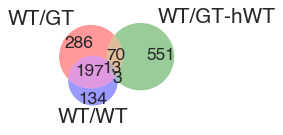

In [46]:
with dataviz.Figure(os.path.join(img_dir, "q331k_vs_control_change.svg"), figsize=(4, 4)) as fig:
    
    ax = fig.add_subplot(2,2,3)
    venn = venn3([set(sig_q331k_vs_ctrls_downregulated.ix['gt', 'unstressed'].index),
                  set(sig_q331k_vs_ctrls_downregulated.ix['hWT', 'unstressed'].index),
                  set(sig_q331k_vs_ctrls_downregulated.ix['rev', 'unstressed'].index),],
                 set_labels=map(lambda x: names[x], ("gt", "hWT", "rev")), 
                 ax=ax)

In [153]:
img_dir

'/home/gpratt/Dropbox/mouse_stress/figures'

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  app.launch_new_instance()
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: Performance

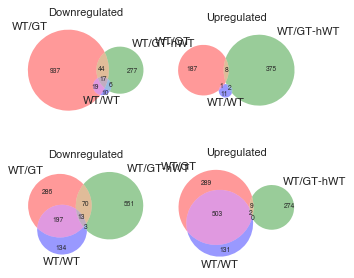

In [152]:
with dataviz.Figure(os.path.join(img_dir, "q331k_vs_control_change.svg"), figsize=(4, 4)) as fig:
    ax = fig.add_subplot(2,2,1)
    venn = venn3([sig_q331k_vs_ctrls_downregulated.ix['gt', 'stressed'].index,
                  sig_q331k_vs_ctrls_downregulated.ix['hWT', 'stressed'].index,
                  sig_q331k_vs_ctrls_downregulated.ix['rev', 'stressed'].index,],
                 set_labels=map(lambda x: names[x], ("gt", "hWT", "rev")), 
                 ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(2,2,2)
    venn = venn3([sig_q331k_vs_ctrls_upregulated.ix['gt', 'stressed'].index,
                  sig_q331k_vs_ctrls_upregulated.ix['hWT', 'stressed'].index,
                  sig_q331k_vs_ctrls_upregulated.ix['rev', 'stressed'].index,],
                 set_labels=map(lambda x: names[x], ("gt", "hWT", "rev")),
                 ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]
    
    ax = fig.add_subplot(2,2,3)
    venn = venn3([set(sig_q331k_vs_ctrls_downregulated.ix['gt', 'unstressed'].index),
                  set(sig_q331k_vs_ctrls_downregulated.ix['hWT', 'unstressed'].index),
                  set(sig_q331k_vs_ctrls_downregulated.ix['rev', 'unstressed'].index),],
                 set_labels=map(lambda x: names[x], ("gt", "hWT", "rev")), 
                 ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(2,2,4)
    venn = venn3([set(sig_q331k_vs_ctrls_upregulated.ix['gt', 'unstressed'].index),
                  set(sig_q331k_vs_ctrls_upregulated.ix['hWT', 'unstressed'].index),
                  set(sig_q331k_vs_ctrls_upregulated.ix['rev', 'unstressed'].index),],
                 set_labels=map(lambda x: names[x], ("gt", "hWT", "rev")),
                 ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]

#Go Analysis

In [48]:
mm10GO = GO.GO(GOFile="/projects/ps-yeolab/genomes/mm10/mm10_ENSEMBL_TO_GO.txt.gz")

In [49]:
expressed_in_ctrl_but_not_q33k1_upregulated = (sig_stress_vs_unstress_upregulated.ix['rev'].index & sig_stress_vs_unstress_upregulated.ix['hWT'].index).difference(sig_stress_vs_unstress_upregulated.ix['q331k'].index)
expressed_in_ctrl_but_not_q33k1_downregulated = (sig_stress_vs_unstress_downregulated.ix['rev'].index & sig_stress_vs_unstress_downregulated.ix['hWT'].index).difference(sig_stress_vs_unstress_downregulated.ix['q331k'].index)

expressed_in_q331k_but_not_ctrl_upregulated = sig_stress_vs_unstress_upregulated.ix['q331k'].index.difference(sig_stress_vs_unstress_upregulated.ix['rev'].index | sig_stress_vs_unstress_upregulated.ix['hWT'].index)
expressed_in_q331k_but_not_ctrl_downregulated = sig_stress_vs_unstress_downregulated.ix['q331k'].index.difference(sig_stress_vs_unstress_downregulated.ix['rev'].index | sig_stress_vs_unstress_downregulated.ix['hWT'].index)

In [50]:
upregluated = pd.DataFrame(expressed_in_ctrl_but_not_q33k1_upregulated)
upregluated['gene_name'] = upregluated.gene_id.apply(lambda x: gene_id_to_name[x])
upregluated.to_csv(os.path.join(img_dir, "genes_expressed_in_ctrl_but_not_q33k1_upregulated.csv"))

downregulated = pd.DataFrame(expressed_in_ctrl_but_not_q33k1_downregulated)
downregulated['gene_name'] = downregulated.gene_id.apply(lambda x: gene_id_to_name[x])
downregulated.to_csv(os.path.join(img_dir, "genes_expressed_in_ctrl_but_not_q33k1_downregulated.csv"))


In [51]:
go_expressed_in_ctrl_but_not_q33k1_upregulated = mm10GO.enrichment(gencode_to_ensembl(expressed_in_ctrl_but_not_q33k1_upregulated))
go_expressed_in_ctrl_but_not_q33k1_downregulated = mm10GO.enrichment(gencode_to_ensembl(expressed_in_ctrl_but_not_q33k1_downregulated))

go_expressed_in_q331k_but_not_ctrl_upregulated = mm10GO.enrichment(gencode_to_ensembl(expressed_in_q331k_but_not_ctrl_upregulated))
go_expressed_in_q331k_but_not_ctrl_downregulated = mm10GO.enrichment(gencode_to_ensembl(expressed_in_q331k_but_not_ctrl_downregulated))

/home/gpratt/anaconda/lib/python2.7/site-packages/gscripts-0.1.6-py2.7.egg/gscripts/GO/GO.py:87: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df = df.sort('Bonferroni-corrected Hypergeometric p-Value')


In [52]:
go_expressed_in_ctrl_but_not_q33k1_upregulated.to_csv(os.path.join(img_dir, "go_expressed_in_ctrl_but_not_q33k1_upregulated.csv"))
go_expressed_in_ctrl_but_not_q33k1_downregulated.to_csv(os.path.join(img_dir, "go_expressed_in_ctrl_but_not_q33k1_downregulated.csv"))

In [53]:
go_expressed_in_ctrl_but_not_q33k1_upregulated = go_expressed_in_ctrl_but_not_q33k1_upregulated[go_expressed_in_ctrl_but_not_q33k1_upregulated['Bonferroni-corrected Hypergeometric p-Value'] < .05]
go_expressed_in_ctrl_but_not_q33k1_downregulated = go_expressed_in_ctrl_but_not_q33k1_downregulated[go_expressed_in_ctrl_but_not_q33k1_downregulated['Bonferroni-corrected Hypergeometric p-Value'] < .05]

In [54]:
go_expressed_in_ctrl_but_not_q33k1_upregulated['log10_p_val'] = go_expressed_in_ctrl_but_not_q33k1_upregulated['Bonferroni-corrected Hypergeometric p-Value'].apply(lambda x: -1 * np.log10(x))
go_expressed_in_ctrl_but_not_q33k1_downregulated['log10_p_val'] = go_expressed_in_ctrl_but_not_q33k1_downregulated['Bonferroni-corrected Hypergeometric p-Value'].apply(lambda x: -1 * np.log10(x))

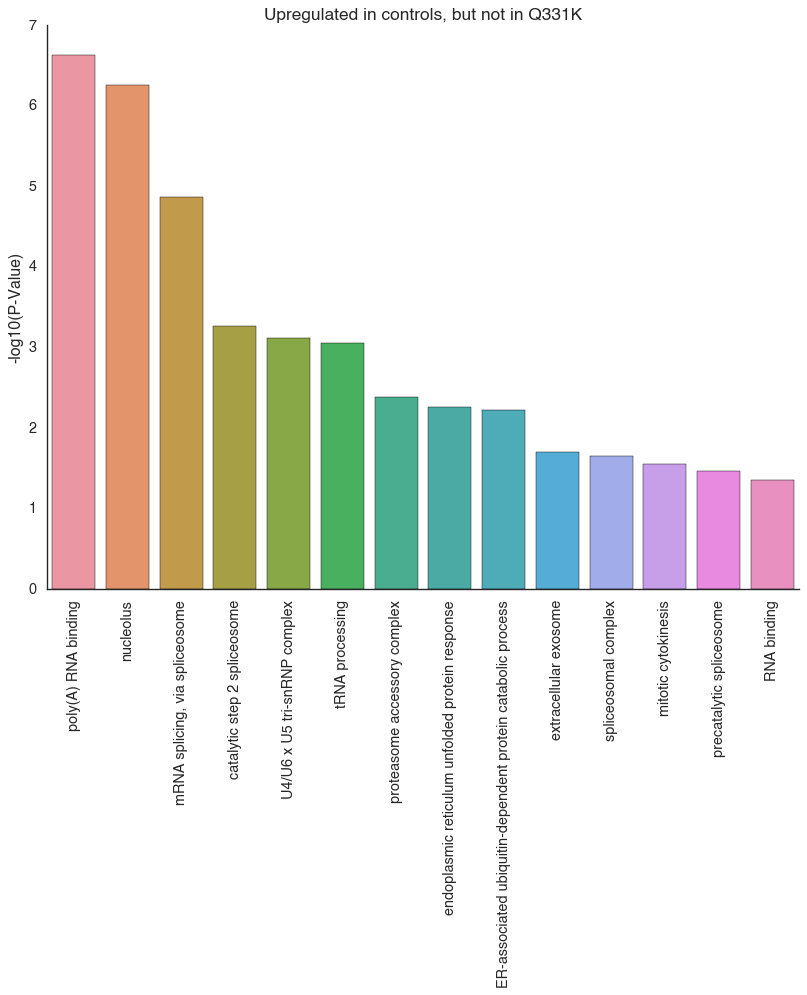

In [55]:
with dataviz.Figure(os.path.join(img_dir, "go_q331k_vs_control_change_upregulated.svg"), figsize=(20, 20)) as fig:
    ax = fig.add_subplot(2,2,1)

    sns.barplot(go_expressed_in_ctrl_but_not_q33k1_upregulated['GO Term Description'].values, 
                go_expressed_in_ctrl_but_not_q33k1_upregulated['log10_p_val'],
               ax=ax,
               )
    [tick.set_rotation(90) for tick in ax.get_xticklabels()]
    ax.set_ylabel("-log10(P-Value)")
    ax.set_title("Upregulated in controls, but not in Q331K")
    sns.despine()

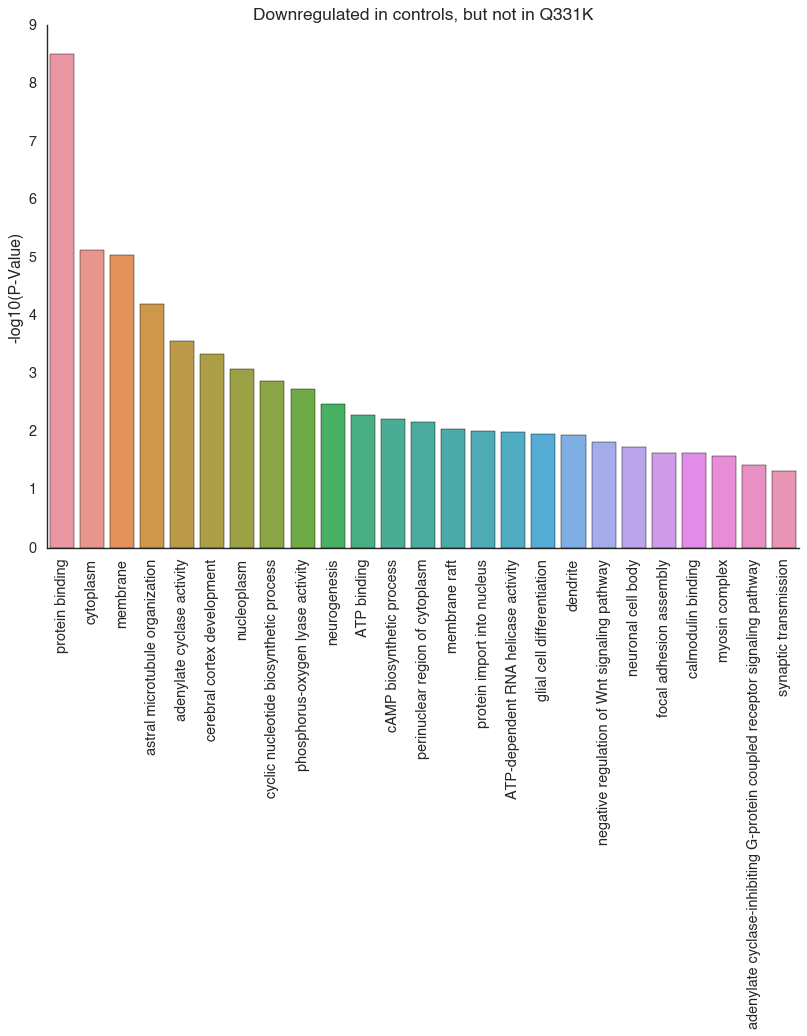

In [56]:
with dataviz.Figure(os.path.join(img_dir, "go_q331k_vs_control_change_downregulated.svg"), figsize=(20, 20)) as fig:
    ax = fig.add_subplot(2,2,1)

    sns.barplot(go_expressed_in_ctrl_but_not_q33k1_downregulated['GO Term Description'].values, 
                go_expressed_in_ctrl_but_not_q33k1_downregulated['log10_p_val'],
               ax=ax,
               )
    [tick.set_rotation(90) for tick in ax.get_xticklabels()]
    ax.set_ylabel("-log10(P-Value)")
    ax.set_title("Downregulated in controls, but not in Q331K")
    sns.despine()

#Try Optimal Leaf Ordering and PCA Clustering

In [57]:
from scipy.cluster import hierarchy
from scipy.spatial import distance

def leaves(t, t2=None):
    """ Returns the leaves of a ClusterNode """
    try:
        return t.pre_order()
    except AttributeError:
        if t2 is not None:
            return t2.pre_order()
        else:
            return []

# For an element x, returns the set that x isn't in
other = lambda x, V, W: W if x in V else V
M = {}

def optimal_scores(v, D, fast=True):
    """ Implementation of Ziv-Bar-Joseph et al.'s leaf order algorithm
    v is a ClusterNode
    D is a distance matrix """
    def score_func(left, right, u, m, w, k):
        return Mfunc(left, u, m) + Mfunc(right, w, k) + D[m, k]
    
    def Mfunc(v, a, b):
        if a == b:
            M[v, a, b] = 0
        return M[v, a, b]
    
    if v.is_leaf():
        n = v.get_id()
        M[v, n, n] = 0
        return 0
    else:
        L = leaves(v.left)
        R = leaves(v.right)
        LL = leaves(v.left.left, v.left)
        LR = leaves(v.left.right, v.left)
        RL = leaves(v.right.left, v.right)
        RR = leaves(v.right.right, v.right)
        for l in L:
            for r in R:
                M[v.left, l, r] = slow_optimal_scores(v.left, D)
                M[v.right, l, r] = slow_optimal_scores(v.right, D)
                for u in L:
                    for w in R:
                        if fast:
                            m_order = sorted(other(u, LL, LR), key=lambda m: Mfunc(v.left, u, m))
                            k_order = sorted(other(w, RL, RR), key=lambda k: Mfunc(v.right, w, k))
                            C = min([D[m, k] for m in other(u, LL, LR) for k in other(w, RL, RR)])
                            Cmin = 1e10
                            for m in m_order:
                                if M[v.left, u, m] + M[v.right, w, k_order[0]] + C >= Cmin:
                                    break
                                for k in k_order:
                                    if M[v.left, u, m] + M[v.right, w, k] + C >= Cmin:
                                        break
                                    C = score_func(v.left, v.right, u, m, w, k)
                                    if C < Cmin:
                                        Cmin = C
                            M[v, u, w] = M[v, w, u] = Cmin
                        else:
                            M[v, u, w] = M[v, w, u] = \
                                min([score_func(v.left, v.right, u, m, w, k) \
                                    for m in other(u, LL, LR) \
                                    for k in other(w, RL, RR)])
                return M[v, l, r]

slow_optimal_scores = lambda v, D: optimal_scores(v, D, fast=False)
fast_optimal_scores = lambda v, D: optimal_scores(v, D, fast=True)

def order_tree(v, D, fM=None, scores=slow_optimal_scores):
    """ Returns an optimally ordered tree """
    # Generate scores the first pass
    if fM is None:
        fM = 1
        scores(v, D)
    
    L = leaves(v.left)
    R = leaves(v.right)
    if len(L) and len(R):
        u, w = min([(u, w) for u in L for w in R], key=lambda (u,w): M[v, u, w])
        if w in leaves(v.right.left):
            v.right.right, v.right.left = v.right.left, v.right.right
        if u in leaves(v.left.right):
            v.left.left, v.left.right = v.left.right, v.left.left
        v.left = order_tree(v.left, D, fM)
        v.right = order_tree(v.right, D, fM)
    return v

In [58]:
@property
def reordered_ind(self):
    M = {}
    tree = hierarchy.to_tree(self.linkage)
    dists = distance.squareform(distance.pdist(self.array, metric=self.metric))
    return leaves(order_tree(tree, dists))

old_ind = sns.matrix._DendrogramPlotter.reordered_ind
sns.matrix._DendrogramPlotter.reordered_ind = reordered_ind

In [59]:
@property
def reordered_ind(self):
    """Indices of the matrix, reordered by the dendrogram"""
    return self.dendrogram['leaves']
sns.matrix._DendrogramPlotter.reordered_ind = reordered_ind

In [60]:
#sns.clustermap(np.log10(unstressed_rpkm_df[bar]).fillna(0))
num_loadings = -1 * 50
#bar = list(set(unstressed_protein_coding_pca.components_.ix['pc_2'].sort_values()[:100].index) | set(unstressed_protein_coding_pca.components_.ix['pc_1'].sort_values()[:100].index))
bar = list(set(unstressed_protein_coding_pca.loadings.ix['pc_2'].sort_values()[num_loadings:].index) | set(unstressed_protein_coding_pca.loadings.ix['pc_1'].sort_values()[num_loadings:].index))
pc2_genes = set(unstressed_protein_coding_pca.loadings.ix['pc_2'].sort_values()[num_loadings:].index)
pc1_genes = set(unstressed_protein_coding_pca.loadings.ix['pc_1'].sort_values()[num_loadings:].index)

In [61]:
unstressed_rpkm_df = rpkm_df.xs(False, level="stress").xs("june", level="date")
zscore = (unstressed_rpkm_df - unstressed_rpkm_df.mean()).div(unstressed_rpkm_df.std())

ordering = ["AV_cont_rev_a", "AV_cont_rev_b", "AV_cont_gt_a", "AV_cont_gt_b", "AV_cont_hWT_A", "AV_cont_hWT_b", "AV_cont_q331k_A", "AV_cont_q331k_b",]
zscore = zscore.reindex(ordering, level='exp')
zscore = zscore.dropna(axis=1)

In [62]:
zscore_subset = zscore[bar] 

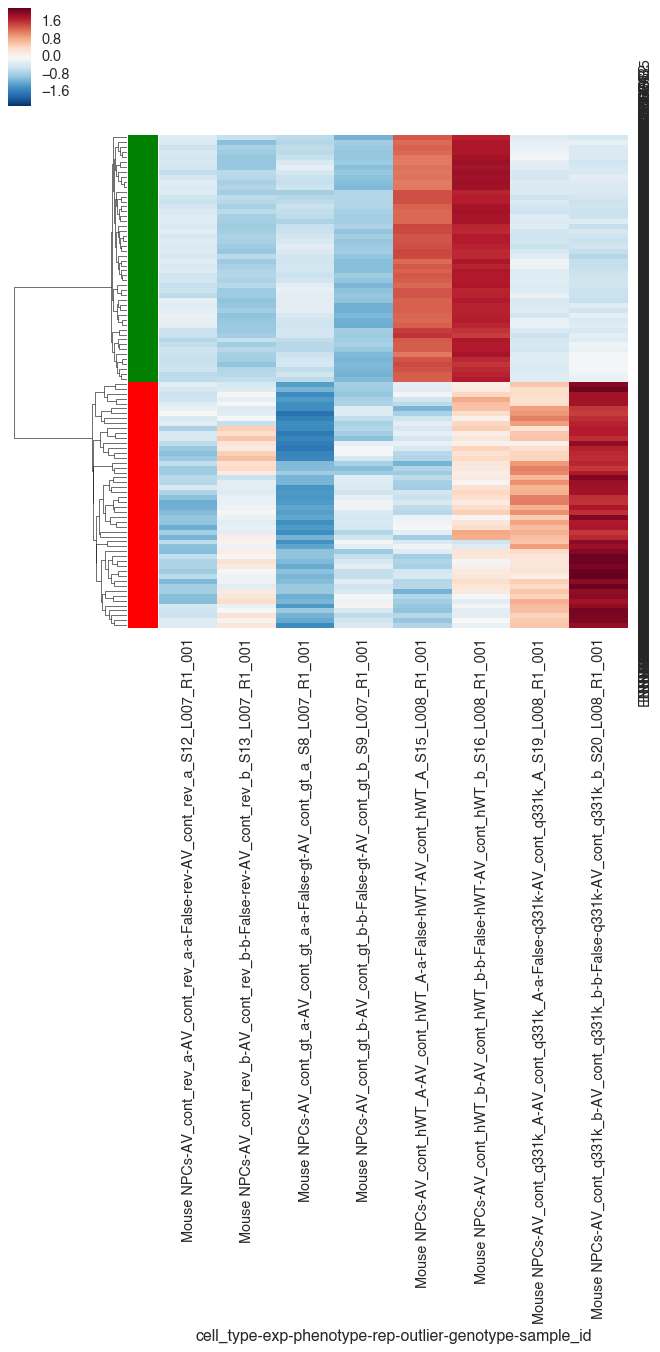

In [63]:
clustergrid = sns.clustermap(zscore_subset.T, col_cluster=False, row_colors=['g' if gene in pc1_genes else 'r' for gene in zscore_subset.columns])

#Fisher Exact Test for differental Enrichment between gene sets

In [64]:
for name, x in mm10GO.GO.iterrows():
    pc1_overlap = len(x['Ensembl Gene ID'] & pc1_genes)
    pc2_overlap = len(x['Ensembl Gene ID'] & pc2_genes)
    
    if pc1_overlap > 0:
        pass
        #print pc1_overlap, pc2_overlap
    pc1_not_overlap = len(pc1_genes) - pc1_overlap
    pc2_not_overlap = len(pc2_genes) - pc2_overlap
    
    
    pval = scipy.stats.fisher_exact([[pc1_overlap, pc2_overlap], [pc1_not_overlap, pc2_not_overlap]])
    if pval < .05:
        print row

#Regular GO Enrichment

In [65]:
result = mm10GO.enrichment(unstressed_protein_coding_pca.components_.ix['pc_2'].sort_values()[-100:].index).dropna()
result = result[result['Bonferroni-corrected Hypergeometric p-Value'] < .05]

In [66]:
result

GO Term Description  \
GO Term Accession                                                      
GO:0005515                                           protein binding   
GO:0005737                                                 cytoplasm   
GO:0045892         negative regulation of transcription, DNA-temp...   
GO:0005654                                               nucleoplasm   
GO:0045668         negative regulation of osteoblast differentiation   
GO:0071260                  cellular response to mechanical stimulus   
GO:0035019                  somatic stem cell population maintenance   
GO:0042802                                 identical protein binding   
GO:0000122         negative regulation of transcription from RNA ...   
GO:0005634                                                   nucleus   
GO:0005730                                                 nucleolus   
GO:0043209                                             myelin sheath   
GO:0044822                                       poly(A) RNA binding   
GO:0030426                                               growth cone   
GO:0007605                               sensory perception of sound   
GO:0042127                          regulation of cell proliferation   
GO:0007420                                         brain development   

                   Bonferroni-corrected Hypergeometric p-Value  \
GO Term Accession                                                
GO:0005515                                            0.000002   
GO:0005737                                            0.000037   
GO:0045892                                            0.000074   
GO:0005654                                            0.000074   
GO:0045668                                            0.000087   
GO:0071260                                            0.000093   
GO:0035019                                            0.000139   
GO:0042802                                            0.000227   
GO:0000122                                            0.000271   
GO:0005634                                            0.000495   
GO:0005730                                            0.000886   
GO:0043209                                            0.001333   
GO:0044822                                            0.002548   
GO:0030426                                            0.013110   
GO:0007605                                            0.017179   
GO:0042127                                            0.025354   
GO:0007420                                            0.045059   

                   N Genes in List and GO Category  \
GO Term Accession                                    
GO:0005515                                      75   
GO:0005737                                      46   
GO:0045892                                      12   
GO:0005654                                      25   
GO:0045668                                       4   
GO:0071260                                       5   
GO:0035019                                       4   
GO:0042802                                      12   
GO:0000122                                      13   
GO:0005634                                      41   
GO:0005730                                      13   
GO:0043209                                       6   
GO:0044822                                      15   
GO:0030426                                       4   
GO:0007605                                       4   
GO:0042127                                       5   
GO:0007420                                       5   

                   N Expressed Genes in GO Category  N Genes in GO category  \
GO Term Accession                                                             
GO:0005515                                    10690                   10690   
GO:0005737                                     5296                    5296   
GO:0045892                                      542                     542   
GO:

In [67]:
result = mm10GO.enrichment(unstressed_protein_coding_pca.components_.ix['pc_2'].sort_values()[:100].index).dropna()
result = result[result['Bonferroni-corrected Hypergeometric p-Value'] < .05]

#Hacked Version of GSEA
http://www.pnas.org/content/102/43/15545.full.pdf?with-ds=yes

My phneotype and ranking are going to be the PCs 1 and 2

In [68]:
pca_loadings = unstressed_protein_coding_pca.loadings.T.copy()
pca_loadings.index = pd.MultiIndex.from_tuples([(gene_id, ensembl_id_to_name[gene_id]) for gene_id in pca_loadings.index], names=['gene_id', 'gene_name'])
pca_loadings.to_csv("/home/gpratt/Dropbox/mouse_stress/data/pca_loadings.csv")

In [69]:
enrichment_df_pc1, hit_values_pc1, enrichment_score_pc1 = mm10GO.gsea(unstressed_protein_coding_pca.loadings.ix["pc_1"], num_iterations=1000)
enrichment_df_pc2, hit_values_pc2, enrichment_score_pc2 = mm10GO.gsea(unstressed_protein_coding_pca.loadings.ix["pc_2"], num_iterations=1000)

In [70]:
enrichment_df_pc1[enrichment_df_pc1['Bonferroni-corrected p-Value'] < .05].sort_values("nes_enrichment", ascending=False)

GO Term Description  enrichment  \
GO:0030054                              cell junction    0.449327   
GO:0030425                                   dendrite    0.447338   
GO:0043025                         neuronal cell body    0.401341   
GO:0045202                                    synapse    0.451617   
GO:0030424                                       axon    0.464358   
GO:0043005                          neuron projection    0.405326   
GO:0045211                      postsynaptic membrane    0.516557   
GO:0043547     positive regulation of GTPase activity    0.356136   
GO:0035556          intracellular signal transduction    0.351772   
GO:0055085                    transmembrane transport    0.330193   
GO:0014069                       postsynaptic density    0.494932   
GO:0005096                  GTPase activator activity    0.390554   
GO:0016567                     protein ubiquitination    0.312142   
GO:0006811                              ion transport    0.405555   
GO:0030154                       cell differentiation    0.306435   
GO:0007268                      synaptic transmission    0.465733   
GO:0005216                       ion channel activity    0.481215   
GO:0008021                           synaptic vesicle    0.523084   
GO:0043234                            protein complex    0.259705   
GO:0019901                     protein kinase binding    0.279502   
GO:0004674   protein serine/threonine kinase activity    0.298580   
GO:0016874                            ligase activity    0.332126   
GO:0042391           regulation of membrane potential    0.466247   
GO:0043197                            dendritic spine    0.470132   
GO:0007399                 nervous system development    0.406446   
GO:0005874                                microtubule    0.321101   
GO:0007612                                   learning    0.640652   
GO:0005488                                    binding    0.277090   
GO:0005856                               cytoskeleton    0.289887   
GO:0097481              neuronal postsynaptic density    0.568249   
...                                               ...         ...   
GO:0030027                              lamellipodium   -0.274719   
GO:0016477                             cell migration   -0.257336   
GO:0003723                                RNA binding   -0.177347   
GO:0003735         structural constituent of ribosome   -0.268625   
GO:0006412                                translation   -0.261817   
GO:0005911                         cell-cell junction   -0.267913   
GO:0042470                                 melanosome   -0.365813   
GO:0008380                               RNA splicing   -0.307475   
GO:0005840                                   ribosome   -0.285462   
GO:0022627          cytosolic small ribosomal subunit   -0.624600   
GO:0001525                               angiogenesis   -0.265215   
GO:0007155                              cell adhesion   -0.201121   
GO:0001725                               stress fiber   -0.490410   
GO:0001666                        response to hypoxia   -0.267631   
GO:0043066   negative regulation of apoptotic process   -0.194959   
GO:0009897           external side of plasma membrane   -0.256494   
GO:0071013               catalytic step 2 spliceosome   -0.427437   
GO:0008284  positive regulation of cell proliferation   -0.195981   
GO:0015629                         actin cytoskeleton   -0.289067   
GO:0005604                          basement membrane   -0.399161   
GO:0030335      positive regulation of cell migration   -0.310526   
GO:0005178                           integrin binding   -0.443577   
GO:0006457                            protein folding   -0.377071   
GO:0005578         proteinaceous extracellular matrix   -0.275271   
GO:0005813                                 centrosome   -0.220277   
GO:0031012                       extracellular matrix   -0.338705   
GO:0051301                      

In [71]:
enrichment_df_pc2[enrichment_df_pc2['Bonferroni-corrected p-Value'] < .05].sort_values("nes_enrichment", ascending=False)
enrichment_df_pc2[enrichment_df_pc2['Bonferroni-corrected p-Value'] < .05].sort_values("nes_enrichment", ascending=False).to_csv("/home/gpratt/Dropbox/mouse_stress/data/pc2_gsea_results.csv")

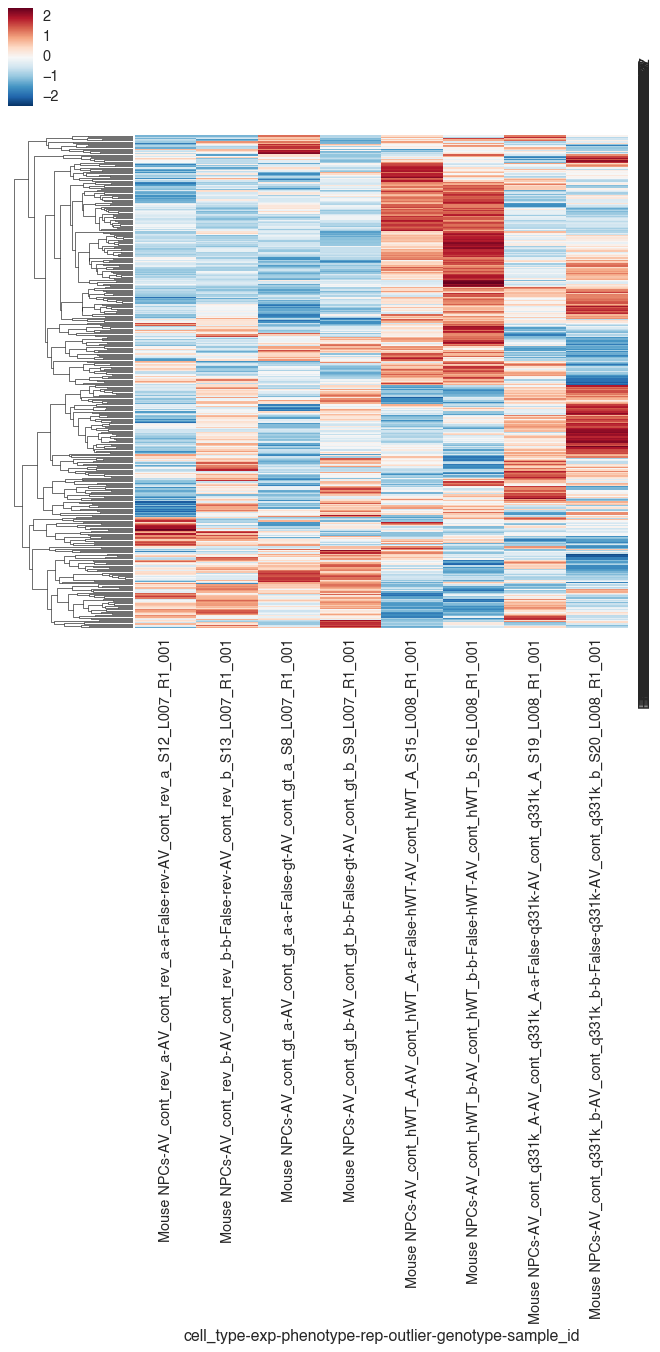

In [72]:
#chromatin binding
go_list = list(mm10GO.GO.ix['GO:0003682']['Ensembl Gene ID'])
sns.clustermap(zscore[zscore.columns & go_list].reindex(ordering, level='exp').T, col_cluster=False)

In [73]:
# go_list = list(mm10GO.GO.ix['GO:0003682']['Ensembl Gene ID'])
# sns.clustermap(np.log2(unstressed_rpkm_df).fillna(0)[unstressed_rpkm_df.columns & go_list].reindex(ordering, level='exp').T, col_cluster=False)

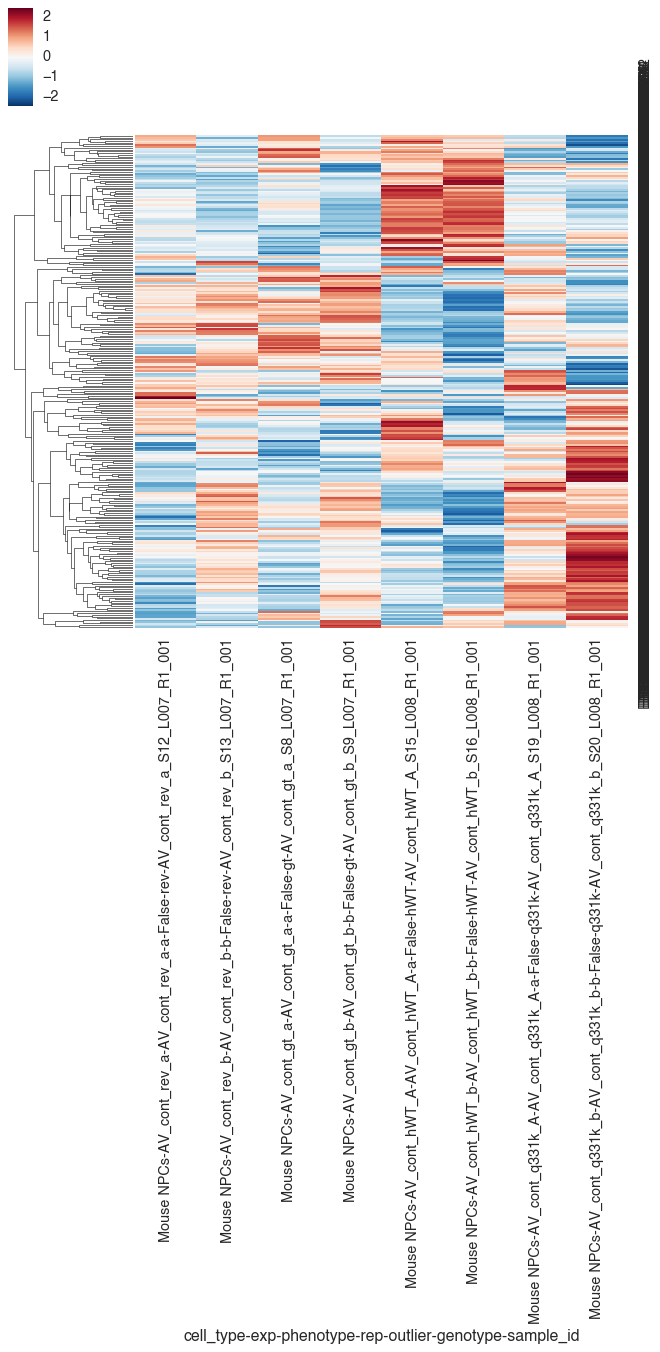

In [74]:
#cell division
go_list = list(mm10GO.GO.ix['GO:0051301']['Ensembl Gene ID'])
sns.clustermap(zscore[zscore.columns & go_list].reindex(ordering, level='exp').T, col_cluster=False)

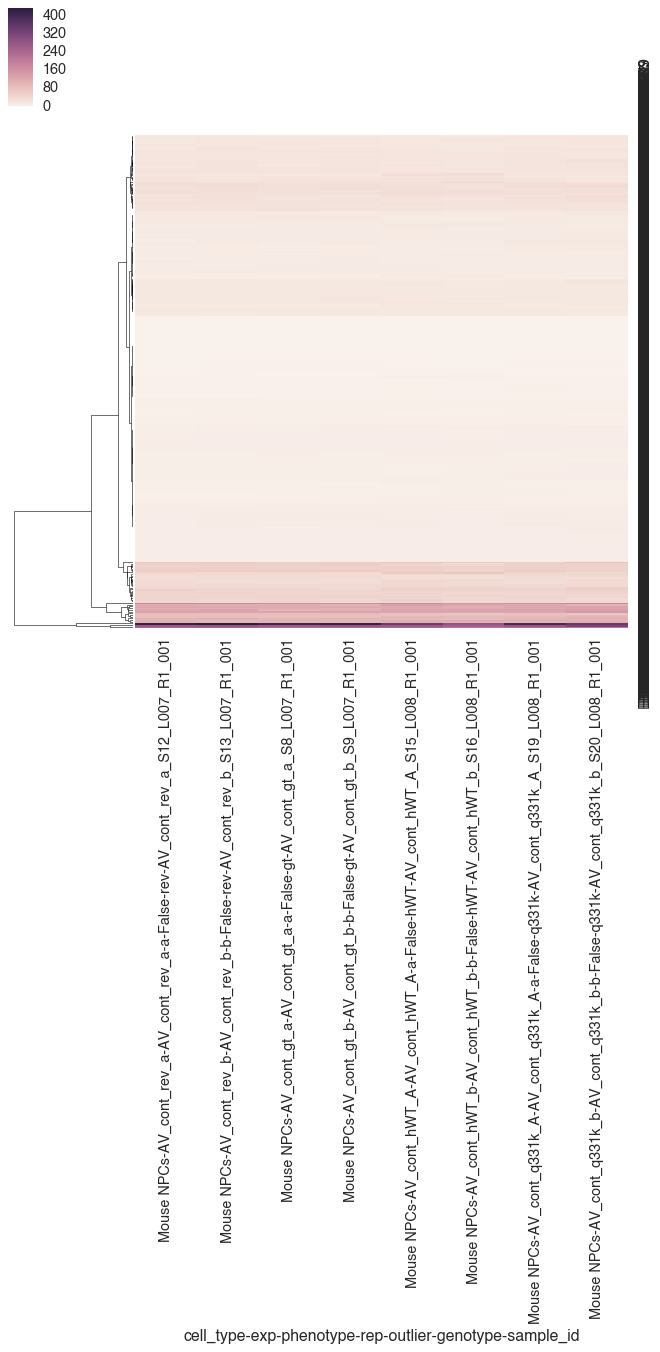

In [75]:
#cell division
go_list = list(mm10GO.GO.ix['GO:0051301']['Ensembl Gene ID'])
sns.clustermap(unstressed_rpkm_df[unstressed_rpkm_df.columns & go_list].reindex(ordering, level='exp').T, col_cluster=False)

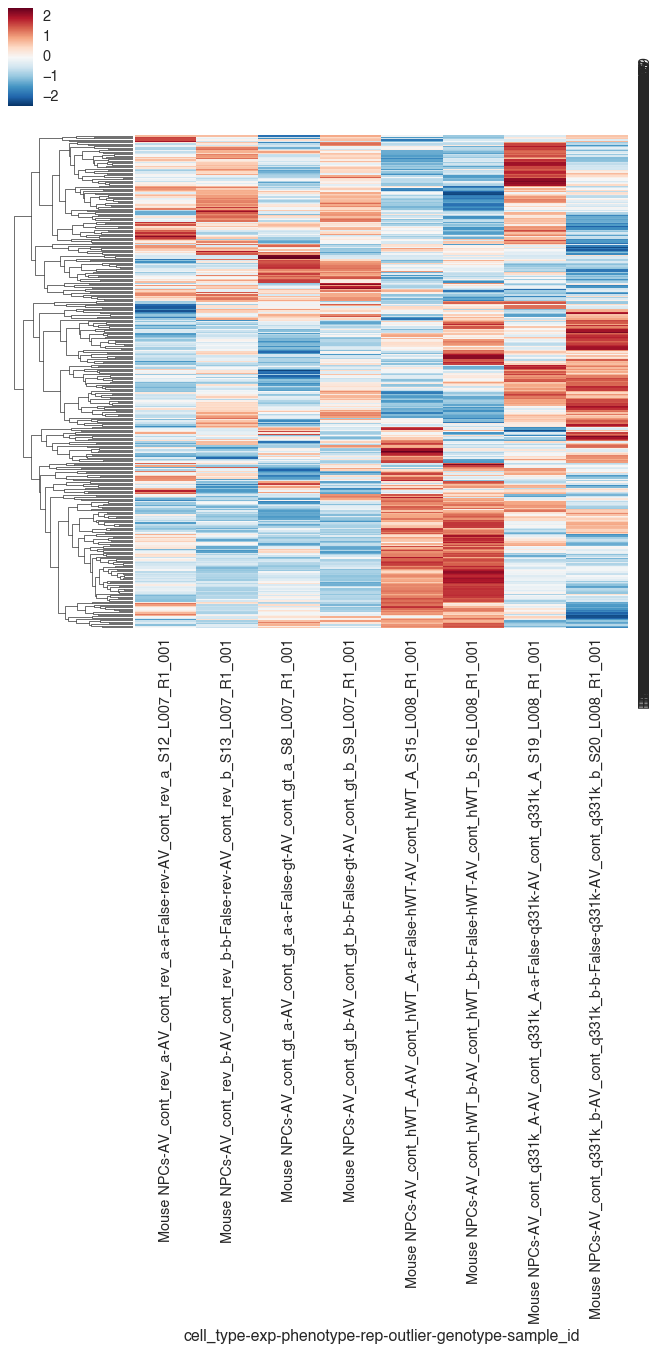

In [76]:
#nucleotide binding
go_list = list(mm10GO.GO.ix['GO:0000166']['Ensembl Gene ID'])
sns.clustermap(zscore[zscore.columns & go_list].reindex(ordering, level='exp').T, col_cluster=False)

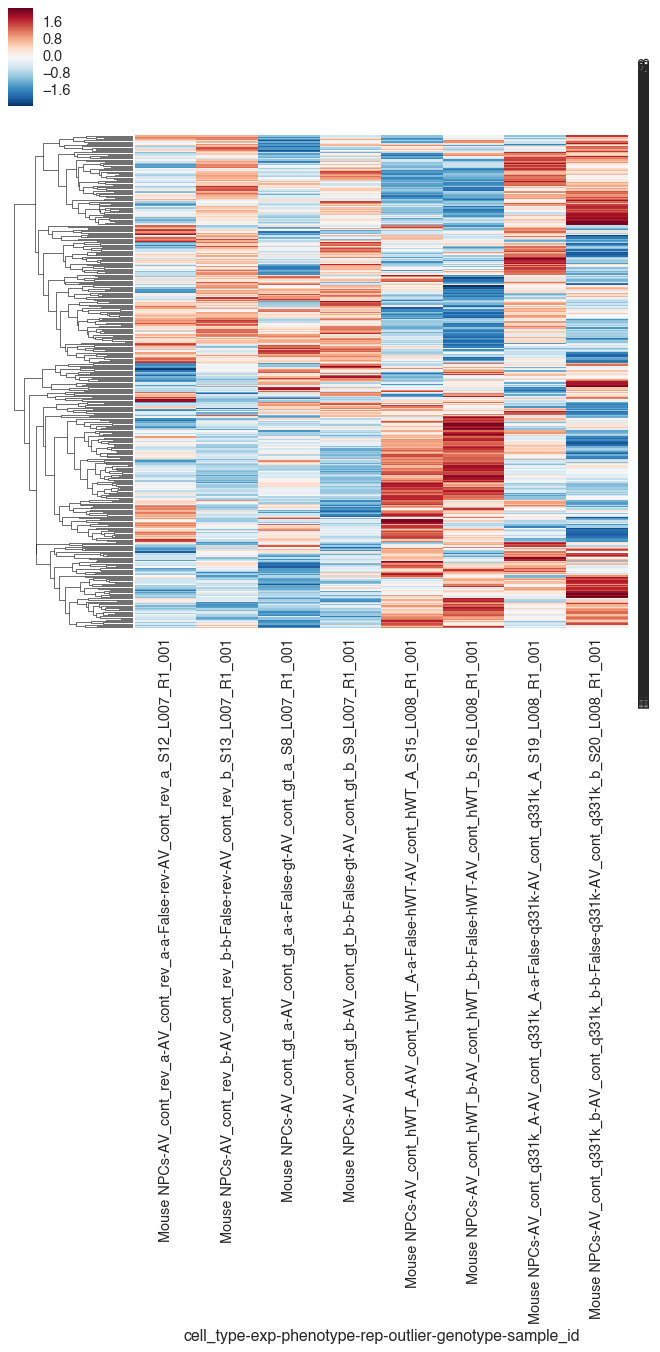

In [77]:
#centrosome
go_list = list(mm10GO.GO.ix['GO:0005813']['Ensembl Gene ID'])
sns.clustermap(zscore[zscore.columns & go_list].reindex(ordering, level='exp').T, col_cluster=False)

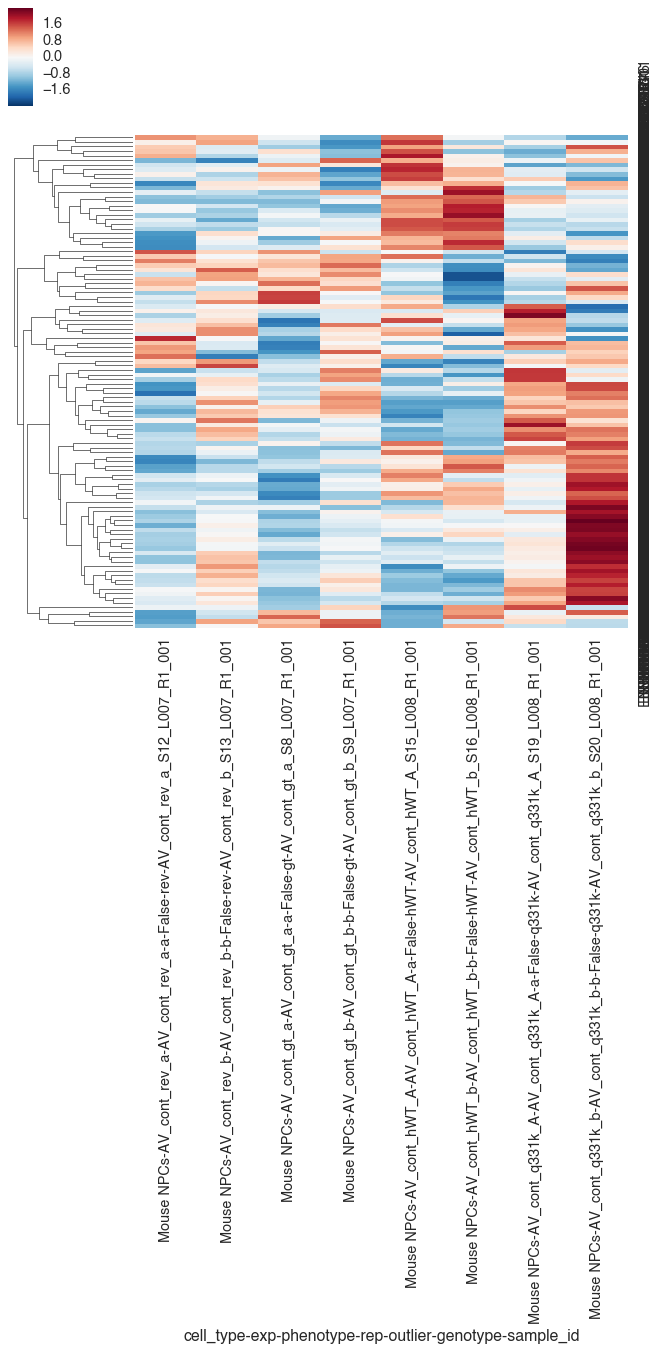

In [78]:
#DNA replication
go_list = list(mm10GO.GO.ix['GO:0006260']['Ensembl Gene ID'])
sns.clustermap(zscore[zscore.columns & go_list].reindex(ordering, level='exp').T, col_cluster=False)

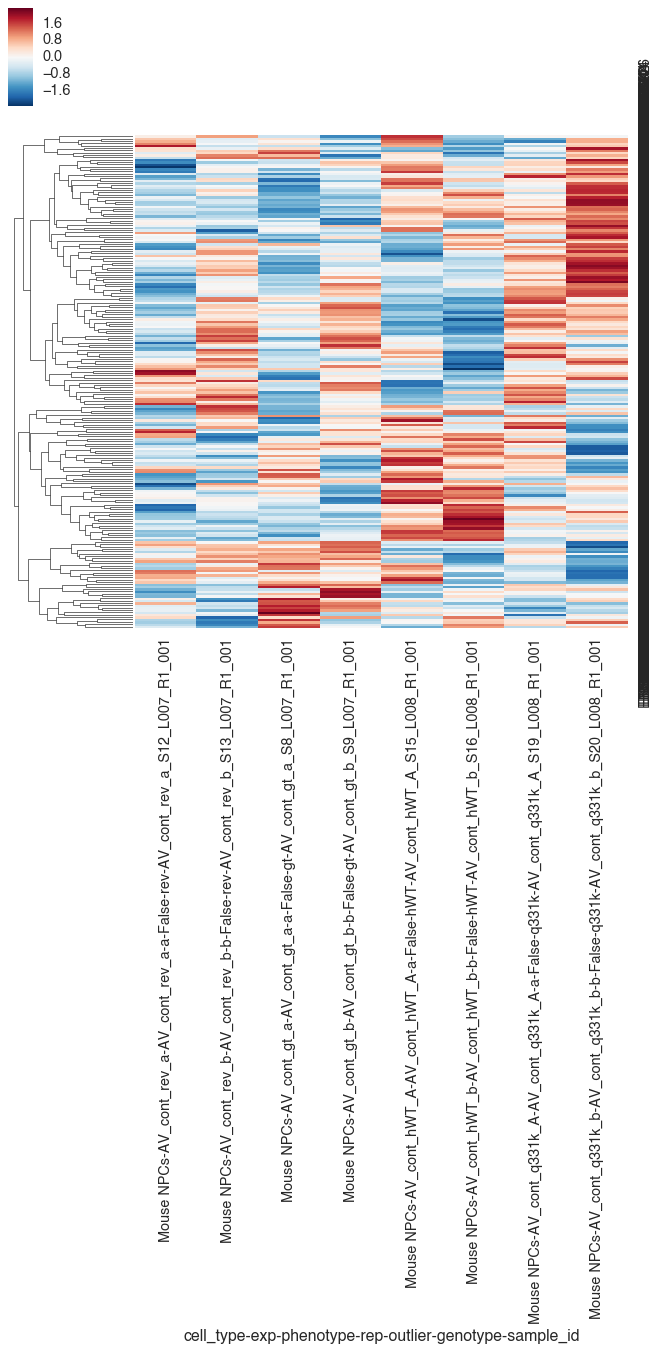

In [79]:
#DNA repair
go_list = list(mm10GO.GO.ix['GO:0006281']['Ensembl Gene ID'])
sns.clustermap(zscore[zscore.columns & go_list].reindex(ordering, level='exp').T, col_cluster=False)

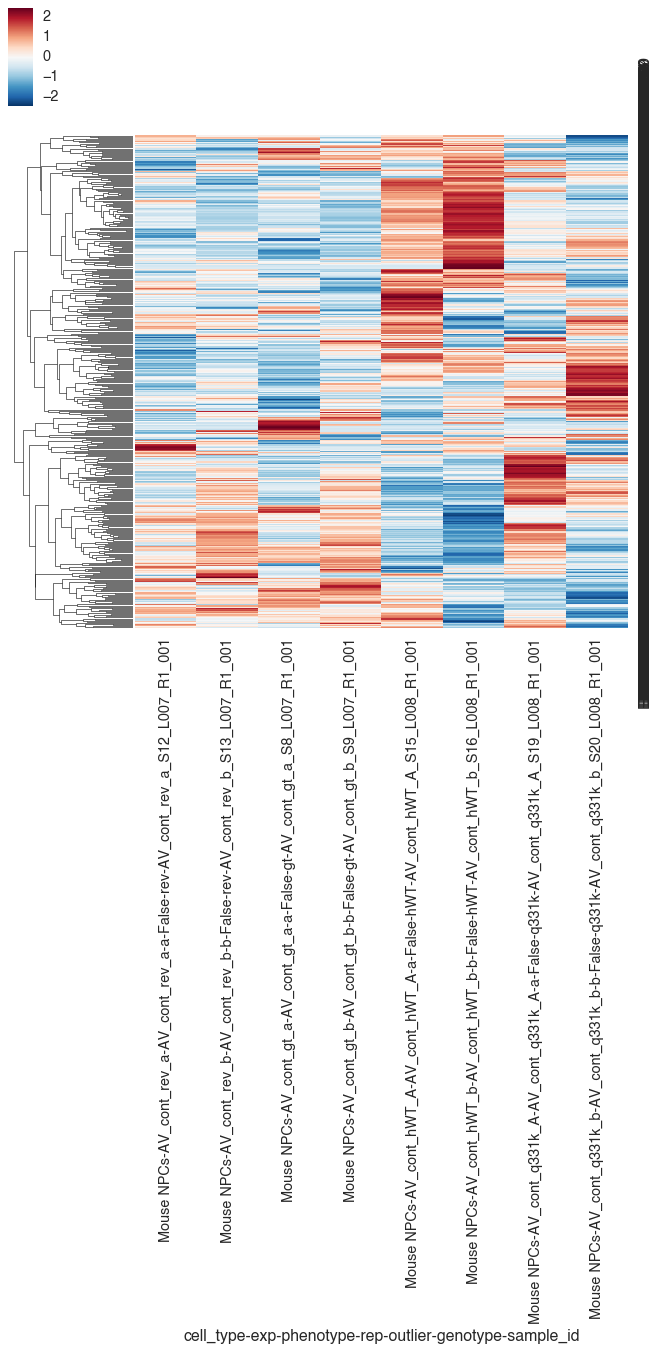

In [80]:
#RNA binding
go_list = list(mm10GO.GO.ix['GO:0003723']['Ensembl Gene ID'])
sns.clustermap(zscore[zscore.columns & go_list].reindex(ordering, level='exp').T, col_cluster=False)

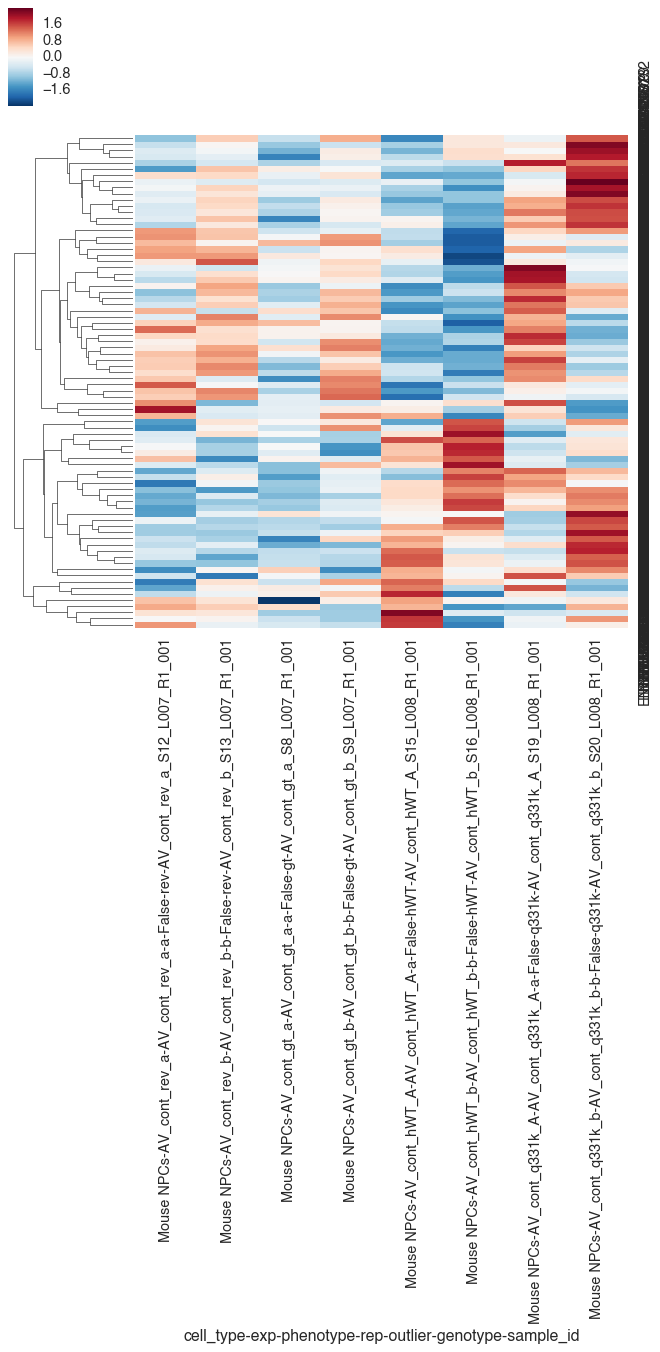

In [81]:
#catalytic step 2 spliceosome
go_list = list(mm10GO.GO.ix['GO:0071013']['Ensembl Gene ID'])
sns.clustermap(zscore[zscore.columns & go_list].reindex(ordering, level='exp').T, col_cluster=False)

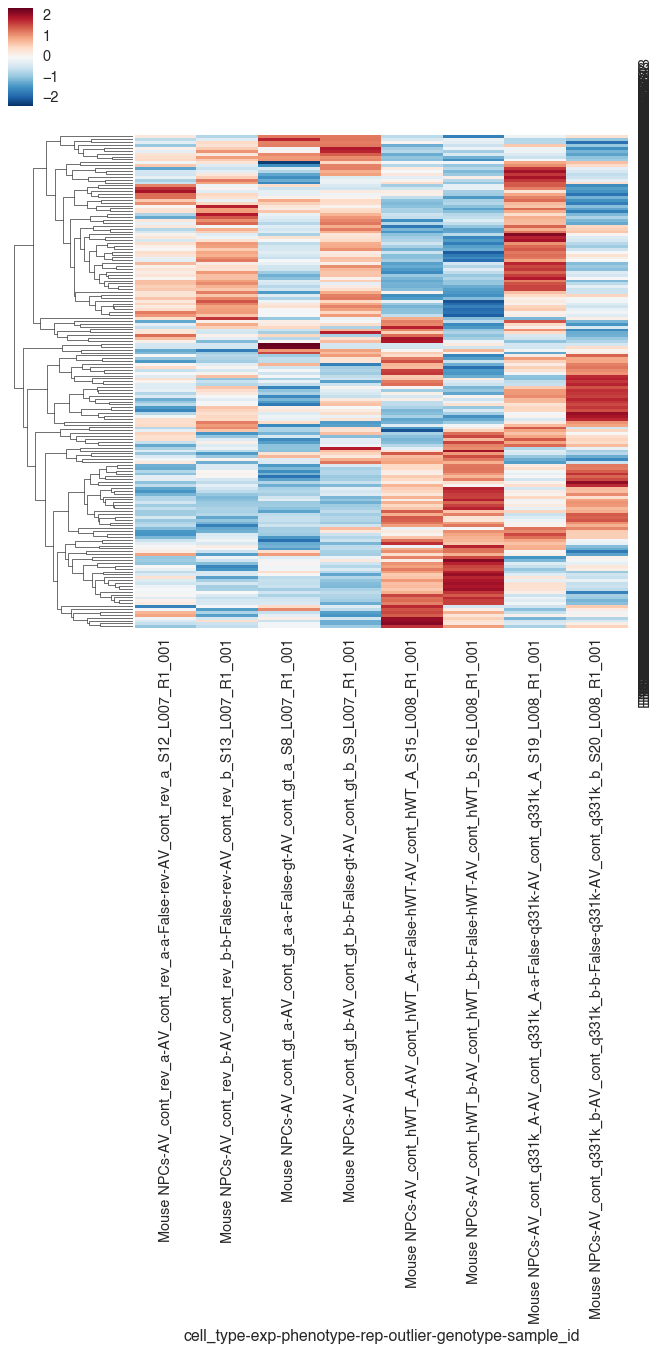

In [82]:
#mRNA processing
go_list = list(mm10GO.GO.ix['GO:0006397']['Ensembl Gene ID'])
sns.clustermap(zscore[zscore.columns & go_list].reindex(ordering, level='exp').T, col_cluster=False)

In [83]:
zscore_clean = zscore.copy()

new_index = []
for row in zscore_clean.index:
    new_index.append([names[row[5]], row[3]])
zscore_clean.index = pd.MultiIndex.from_tuples(new_index)

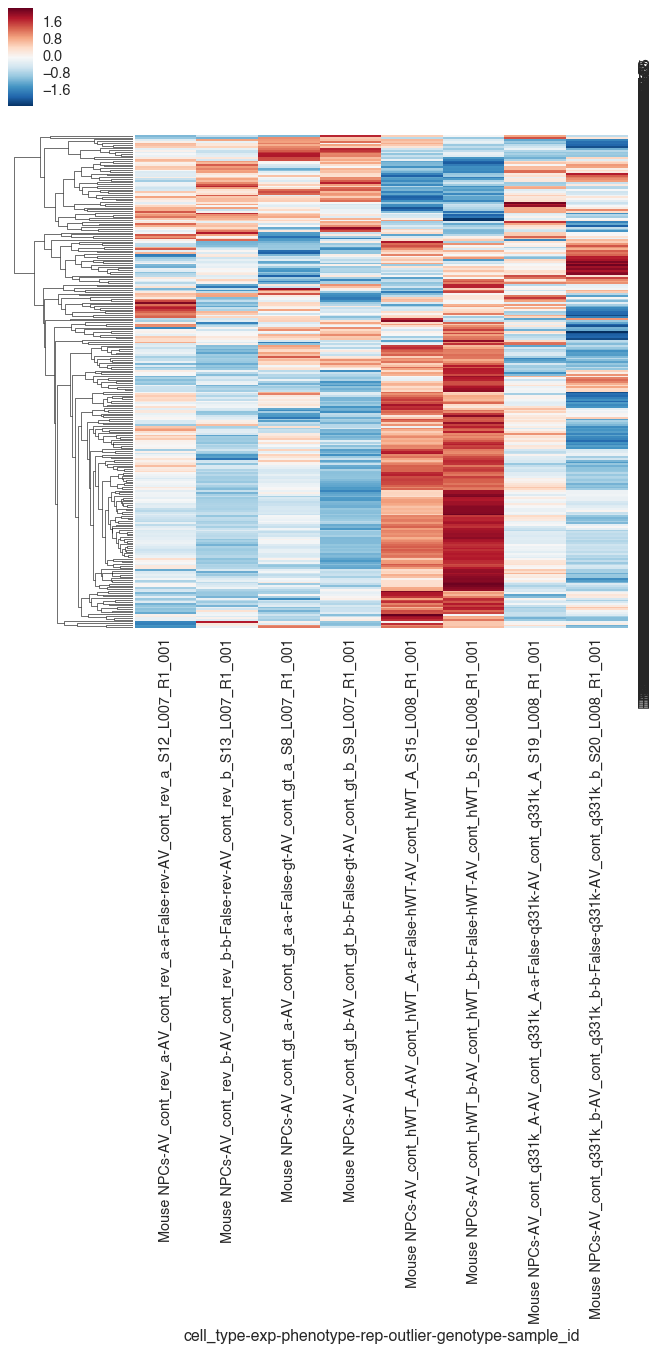

In [84]:
#Axon, PC1
go_list = list(mm10GO.GO.ix['GO:0030424']['Ensembl Gene ID'])
sns.clustermap(zscore[zscore.columns & go_list].reindex(ordering, level='exp').T, col_cluster=False)
pyplot.savefig(os.path.join(img_dir, "pc1_axon_clustergram.svg"))
pyplot.savefig(os.path.join(img_dir, "pc1_axon_clustergram.pdf"))

In [85]:
foo = zscore[zscore.columns & go_list].xs("AV_cont_hWT_A", level="phenotype").T
foo = foo.sort_values(foo.columns[0], ascending=False).copy()
foo.index = [ensembl_id_to_name[gene_id] for gene_id in foo.index]
#" ".join(foo.index)

", ".join(foo[foo > 0].dropna().index)

'Pvalb, Ucn, Kcna3, Cpne6, Calb1, Pink1, Kif13b, Chrna10, Slc6a3, Cpt1c, Dtnbp1, Sncg, Lsm1, Coro1a, Hmbs, Avil, Ngdn, Mgll, Klhl20, Snca, Tgfb1, Stmn4, Scn11a, Snap25, Calca, Kcnab2, Stmn3, Serpinf1, Pak1, Penk, Atl1, Prss12, Rab3a, Robo3, Adam22, Tmem57, Maf1, Zfyve27, Cdk5r1, Prph, Gad2, Cadm1, Hpca, Mul1, Map3k12, Uchl1, Mapk8ip1, Gap43, Fez1, Fam168b, Alcam, P2rx3, Klc1, Nrgn, Pafah1b1, Psen1, Tpgs1, Drd4, Nefh, Ntrk1, Cdk5, Ncam2, Kcna2, Hcn1, Nek3, Lrrtm1, Car2, Sarm1, Tubb3, Ptpn5, Kif21a, Kcnh1, Ddc, Vps16, Dcc, Psen2, Adora2a, Adcy9, Fgf13, Rufy3, Atcay, Stmn2, Casr, Gars, Scn2a1, Nefl, Ldlrap1, Htr3a, Trpv2, Npy1r, Mapt, Irx3, Nrcam, Sphk1, Ndel1, Kcna1, Ret, Kcna6, Nefm, Slc5a7, Igf2bp1, Rap1gap, Ywhae, Olfm1, Hap1, Dab2ip, Drd1a, Hcn3, Ncs1, Acadm, Spg11, Ap3d1, Hdac6, Nrp2, Cck, Park7, Gsk3b, Unc13a, Apc, Htt, Epha5, Dicer1, Cntn2, Mapk1, Atat1, Dvl1, Sptbn4, Ctnna2, Nrtn, Atp1a3, Nfasc, Gc, 4930506M07Rik, Disc1, Hcfc1, Palm, Drd2, Pygb, Cntnap1, Tac1, Lphn3, Ank3, Srcin1

In [86]:
foo.to_csv("/home/gpratt/Dropbox/mouse_stress/data/PC1_WT-hWT_zscore_gene_rank.csv")

ValueError: could not convert string to float: ENSMUSG00000025950

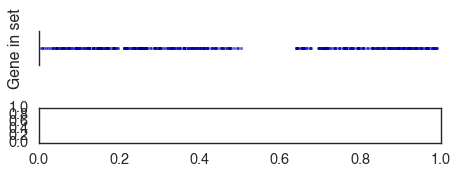

In [87]:
with dataviz.Figure(os.path.join(img_dir, "chromatin_binding.svg"), figsize=(6, 3)) as fig:
    GO.plot_go_term("GO:0003682", unstressed_protein_coding_pca.loadings.ix["pc_2"], hit_values_pc1, enrichment_score_pc1, fig)

ValueError: could not convert string to float: ENSMUSG00000007458

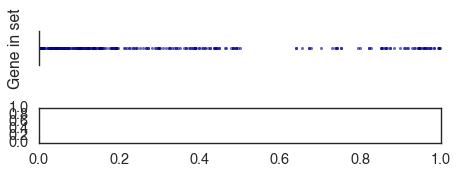

In [88]:
with dataviz.Figure(os.path.join(img_dir, "axon_pc1.svg"), figsize=(6, 3)) as fig:
    GO.plot_go_term("GO:0030424", unstressed_protein_coding_pca.loadings.ix["pc_1"], hit_values_pc1, enrichment_score_pc1, fig)

# Compare humanized with mutant and both with the mouse controls

In [89]:
unstressed_comparison = pd.concat({(os.path.basename(item).split("_")[0], os.path.basename(item).split("_")[2]): pd.read_csv(item, index_col=0) for item in  glob.glob("/home/gpratt/Dropbox/cryptic_splicing/data/mouse_data/*unstressed.csv")})
unstressed_comparison.index.names = ['genotype_1', 'genotype_2', 'gene_id']
unstressed_comparison['gene_id'] = unstressed_comparison.index.get_level_values(level="gene_id")

sig_unstressed_comparison = unstressed_comparison[(unstressed_comparison.padj <= .05)  & (abs(unstressed_comparison.log2FoldChange) > np.log2(1.5))]
sig_unstressed_comparison_upregulated = sig_unstressed_comparison[sig_unstressed_comparison.log2FoldChange > 0]
sig_unstressed_comparison_downregulated = sig_unstressed_comparison[sig_unstressed_comparison.log2FoldChange < 0]

In [90]:
pd.concat({"upregulated": sig_unstressed_comparison_upregulated.groupby(level=["genotype_1", 'genotype_2']).count().baseMean,
           "downregulated": sig_unstressed_comparison_downregulated.groupby(level=["genotype_1", 'genotype_2']).count().baseMean})

               genotype_1  genotype_2
downregulated  hWT         gt            483
                           rev           328
               q331k       gt            273
                           hWT           637
                           rev            29
               rev         gt             67
upregulated    hWT         gt            783
                           rev           634
               q331k       gt             24
                           hWT           285
                           rev             3
               rev         gt              3
Name: baseMean, dtype: int64

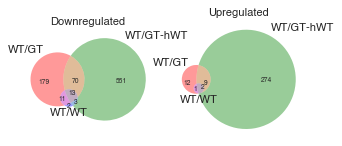

In [91]:
with dataviz.Figure(os.path.join(img_dir, "unstressed_all_changes.svg"), figsize=(4, 2)) as fig:
    ax = fig.add_subplot(1,2,1)
    venn = venn3([sig_unstressed_comparison_downregulated.ix['q331k', 'gt'].index,
                  sig_unstressed_comparison_downregulated.ix['q331k', 'hWT'].index,
                  sig_unstressed_comparison_downregulated.ix['q331k', 'rev'].index,],
            set_labels=map(lambda x: names[x], ("gt", "hWT", "rev")), 
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(1,2,2)
    venn = venn3([sig_unstressed_comparison_upregulated.ix['q331k', 'gt'].index,
                  sig_unstressed_comparison_upregulated.ix['q331k', 'hWT'].index,
                  sig_unstressed_comparison_upregulated.ix['q331k', 'rev'].index,],
            set_labels=map(lambda x: names[x], ("gt", "hWT", "rev")),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]

/home/gpratt/anaconda/lib/python2.7/site-packages/matplotlib_venn-0.10-py2.7.egg/matplotlib_venn/_venn2.py:132: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()


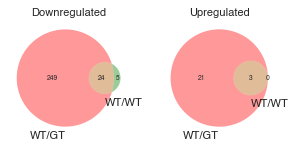

In [92]:
with dataviz.Figure(os.path.join(img_dir, "unstressed_q33k1_comparisons.svg"), figsize=(4, 2)) as fig:
    ax = fig.add_subplot(1,2,1)
    venn = venn2([sig_unstressed_comparison_downregulated.ix['q331k', 'gt'].index,
                  sig_unstressed_comparison_downregulated.ix['q331k', 'rev'].index,],
            set_labels=map(lambda x: names[x], ("gt", "rev")), 
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(1,2,2)
    venn = venn2([sig_unstressed_comparison_upregulated.ix['q331k', 'gt'].index,
                  sig_unstressed_comparison_upregulated.ix['q331k', 'rev'].index,],
            set_labels=map(lambda x: names[x], ("gt", "rev")),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]

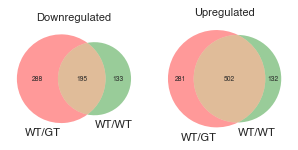

In [93]:
with dataviz.Figure(os.path.join(img_dir, "unstressed_hWT_comparisons.svg"), figsize=(4, 2)) as fig:
    ax = fig.add_subplot(1,2,1)
    venn = venn2([sig_unstressed_comparison_downregulated.ix['hWT', 'gt'].index,
                  sig_unstressed_comparison_downregulated.ix['hWT', 'rev'].index,],
            set_labels=map(lambda x: names[x], ("gt", "rev")), 
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(1,2,2)
    venn = venn2([sig_unstressed_comparison_upregulated.ix['hWT', 'gt'].index,
                  sig_unstressed_comparison_upregulated.ix['hWT', 'rev'].index,],
            set_labels=map(lambda x: names[x], ("gt", "rev")),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]

Looks like it might be a loss of function? That could explain why the Q331k Mutation has fewer changes than the humanized version?

downregulated q331k hWT           637
upregulated   q331k hWT           285


In [94]:
def plot_both_changing(genotype_1, vs_1, genotype_2, vs_2, outfile):
    significantly_enriched_genes_either = sig_unstressed_comparison.ix[genotype_1, vs_1].index.get_level_values(level="gene_id") | sig_unstressed_comparison.ix[genotype_2, vs_2].index.get_level_values(level="gene_id")
    changing_in_either = unstressed_comparison[unstressed_comparison.gene_id.isin(significantly_enriched_genes_either)].log2FoldChange.unstack()
    print len(significantly_enriched_genes_either)
    with dataviz.Figure(outfile, figsize=(4, 4)) as fig:
        ax = fig.add_subplot(1,1,1)
        KA, WT, middle = ['r','b', 'g']
        ka_genes = sig_unstressed_comparison.ix[genotype_1, vs_1].index.get_level_values(level="gene_id")
        wt_genes = sig_unstressed_comparison.ix[genotype_2, vs_2].index.get_level_values(level="gene_id")


        colors = []
        for gene in changing_in_either.columns:
            if gene in ka_genes and gene in wt_genes:
                colors.append(middle)
            elif gene in ka_genes:
                colors.append(KA)
            elif gene in wt_genes:
                colors.append(WT)

        ax.scatter(changing_in_either.ix[genotype_1, vs_1].values, changing_in_either.ix[genotype_2, vs_2].values, alpha=.7, 
                   color=colors, 
                   s=5)
        ax.set_xlabel("{} vs {} Log2 Fold Change".format(names[genotype_1], names[vs_1]), fontsize=10)
        ax.set_ylabel("{} vs {} Log2 Fold Change".format(names[genotype_2], names[vs_2]), fontsize=10)
        #ax.set_title("Differental Espression of WT vs KA Mutant")
        ax.set_xlim(-4, 4)
        ax.set_ylim(-4, 4)

        red_patch = mpatches.Patch(color='r', label="{} vs {}".format(names[genotype_1], names[vs_1]))
        blue_patch = mpatches.Patch(color='b', label="{} vs {}".format(names[genotype_2], names[vs_2]))
        green_patch = mpatches.Patch(color='g', label='Both')


        ax.legend(handles=[red_patch, blue_patch, green_patch], loc=0)
        sns.despine(ax=ax)

980


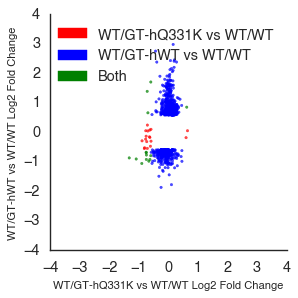

In [95]:
plot_both_changing('q331k', 'rev', 'hWT', 'rev', os.path.join(img_dir, "q331k_and_hwt_vs_rev.svg"))

300


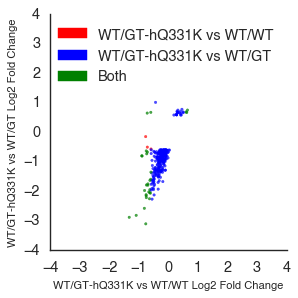

In [96]:
plot_both_changing('q331k', 'rev', 'q331k', 'gt', os.path.join(img_dir, "q331k_vs_rev_and_gt.svg"))

1531


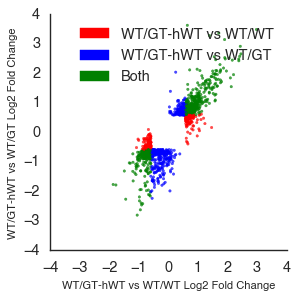

In [97]:
plot_both_changing('hWT', 'rev', 'hWT', 'gt', os.path.join(img_dir, "hWT_vs_rev_and_gt.svg"))

1366


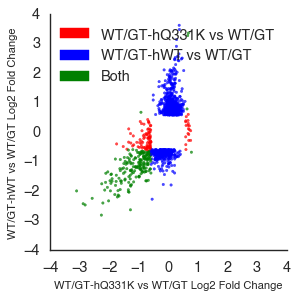

In [98]:
plot_both_changing('q331k', 'gt', 'hWT', 'gt', os.path.join(img_dir, "q331k_and_hwt_vs_gt.svg"))

980


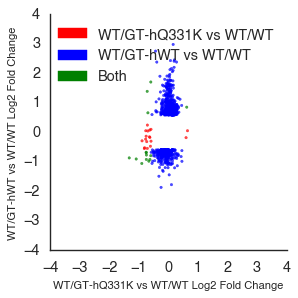

In [99]:
plot_both_changing('q331k', 'rev', 'hWT', 'rev', os.path.join(img_dir, "q331k_and_hwt_vs_rev.svg"))

#GO Analysis on unstress comparisons

In [100]:
sig_unstressed_comparison_upregulated = sig_unstressed_comparison[sig_unstressed_comparison.log2FoldChange > 0]
sig_unstressed_comparison_downregulated = sig_unstressed_comparison[sig_unstressed_comparison.log2FoldChange < 0]

In [114]:
#Factor this to a helpers function
def gencode_to_ensembl(gene_list):
    for gene in gene_list:
        yield gene.split(".")[0]

In [115]:
go_results = {}
for name, df in sig_unstressed_comparison_upregulated.groupby(level=[0,1]):
    go = mm10GO.enrichment(gencode_to_ensembl(df.gene_id.dropna()))
    go = go[go['Bonferroni-corrected Hypergeometric p-Value'] < .05]
    go_results[tuple(['upregulated'] + list(name))] = go
    
for name, df in sig_unstressed_comparison_downregulated.groupby(level=[0,1]):
    go = mm10GO.enrichment(gencode_to_ensembl(df.gene_id.dropna()))
    go = go[go['Bonferroni-corrected Hypergeometric p-Value'] < .05]
    go_results[tuple(['downregulated'] + list(name))] = go

go_results = pd.concat(go_results, names=['direction', 'genotype_1', 'genotype_2', 'GO Term ID'])

In [116]:
new_index = []
for row in go_results.index:
    inc, gt_1, gt_2, go_term = row
    new_index.append([inc, names[gt_1], names[gt_2], go_term])
go_results.index = pd.MultiIndex.from_tuples(new_index)

In [117]:
go_results.to_csv("/home/gpratt/Dropbox/mouse_stress/data/expression_go_analysis.csv")

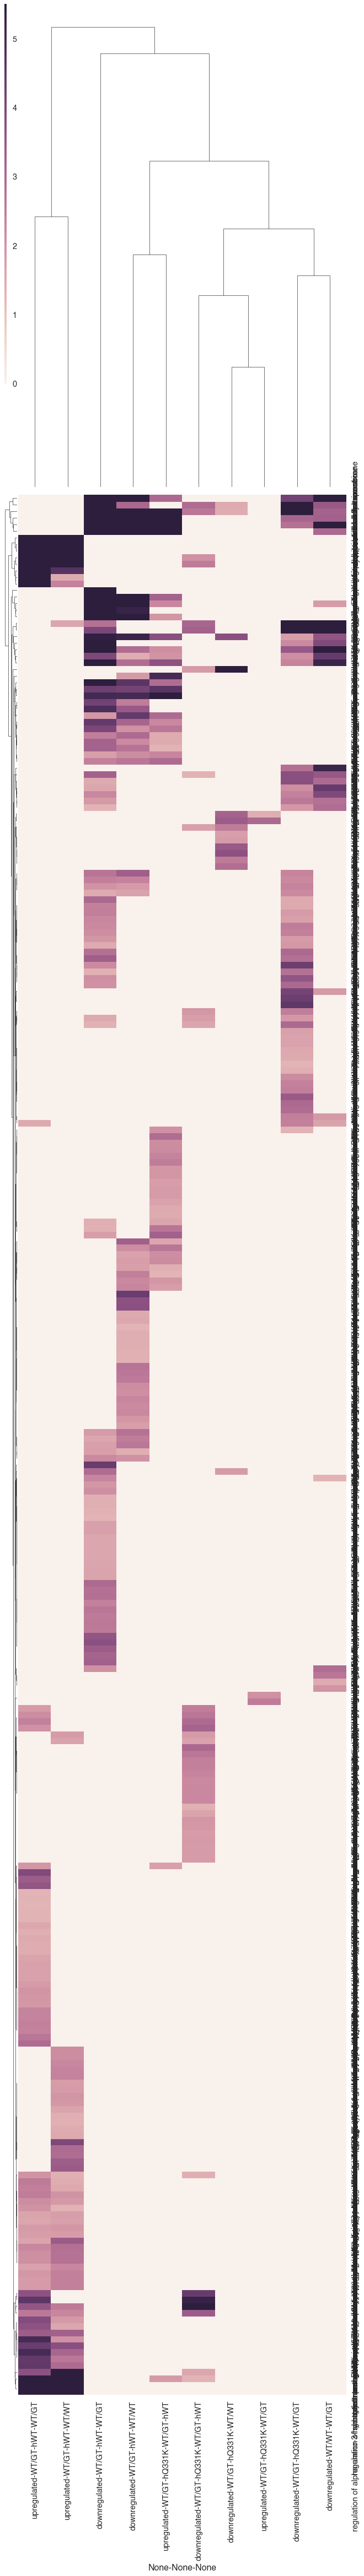

In [118]:
dataviz.plot_go_enrichment(go_results, figsize=(10,70))
pyplot.savefig(os.path.join(img_dir, "expression_go_clustergram.svg"))
pyplot.savefig(os.path.join(img_dir, "expression_go_clustergram.pdf"))

#Generate Splicing Comparisons
Going overkill with all the SE events because fuck it, computation is cheap, I'll figure it out later.  

In [119]:
splicing_events = sorted(glob.glob("/projects/ps-yeolab2/for_anthony/analysis/av_mouse_stress_v3/miso/*"))

In [120]:
miso_commands = []
for rep1, rep2 in itertools.permutations(splicing_events, 2):
    outfile = os.path.join("/home/gpratt/projects/for_anthony/analysis/miso_out_v2/SE", os.path.basename(rep1) + "_vs_" + os.path.basename(rep2))
    #print os.path.basename(rep1), os.path.basename(rep2)
    miso_commands.append("compare_miso --compare-samples {} {} {}".format(os.path.join(rep1, "SE"), os.path.join(rep2, "SE"), outfile))

In [121]:
def eplouge(name,count, run_dir="/home/gpratt/projects/encode/analysis/idr_analysis_p_value/"):
    return """#!/bin/bash
#PBS -N {0}
#PBS -l nodes=1:ppn=1
#PBS -o {0}.out
#PBS -e {0}.err
#PBS -V
#PBS -q home-yeo
#PBS -W group_list=yeo-group
#PBS -t 1-{1}
#PBS -l walltime=4:00:00
cd {2}
echo "hello, starting"
""".format(name, count, run_dir)

prolouge = "eval ${cmd[$PBS_ARRAYID]}"

In [122]:
total = 0 
result = []
for cmd in miso_commands:
    total += 1
    result.append('cmd[{}]="{}"'.format(total, cmd))
    
with open(os.path.join("/home/gpratt/projects/for_anthony/scripts/", "miso_compare.sh"), 'w') as out_file:
    out_file.write(eplouge("miso_compare", total, "/home/gpratt/projects/for_anthony/analysis/miso_out_v2/" ))
    for line in result:
        out_file.write(line + "\n\n")
    out_file.write(prolouge + "\n")

#Now analyze all this ish...

Analysis has been moved to the splicing anlaysis notebook

#Test Dynamic Range idea gene had

In [123]:
scaled_range = flotilla_rpkm_df[metadata.date == "june"].copy()

In [124]:
scaled_range = scaled_range.div(scaled_range.sum(axis=1), axis=0)
mn_study_stress_scaled_samples = flotilla.Study(# The metadata describing phenotype and pooled samples
                       metadata,
                       # A version for this data
                       version='0.1.0',
                       expression_data = scaled_range,
                       # Dataframe of the splicing data
                       splicing_data=splicing_df[metadata.date == "june"],
                       expression_thresh = 1,
                       species="mm10"
)

2017-03-03 16:15:53 	Initializing Study
2017-03-03 16:15:53 	Initializing Predictor configuration manager for Study
2017-03-03 16:15:53	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2017-03-03 16:15:53	Added ExtraTreesClassifier to default predictors
2017-03-03 16:15:53	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2017-03-03 16:15:53	Added ExtraTreesRegressor to default predictors
2017-03-03 16:15:53	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2017-03-03 16:15:53	Added GradientBoostingClassifier to default predictors
2017-03-03 16:15:53	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
2017-03-03 16:15:53	Added GradientBoostingRegressor to default predictors
2017-03-03 16:15:53 	Loading metadata
2017-03-03 16:15:54	Loading species metadata from 

No phenotype to color mapping was provided, falling back on reasonable defaults.
No phenotype to marker (matplotlib plotting symbol) was provided, falling back on reasonable defaults.


https://s3-us-west-2.amazonaws.com/flotilla-projects/ercc/ERCC_Controls.txt has not been downloaded before.
2017-03-03 16:15:55	Loading expression data
2017-03-03 16:15:55	Initializing expression


Error loading species mm10 data: HTTP Error 404: Not Found

2017-03-03 16:15:55	Done initializing expression
2017-03-03 16:15:56	Loading splicing data
2017-03-03 16:15:56	Initializing splicing
2017-03-03 16:15:56	Done initializing splicing
2017-03-03 16:15:56	Successfully initialized a Study object!


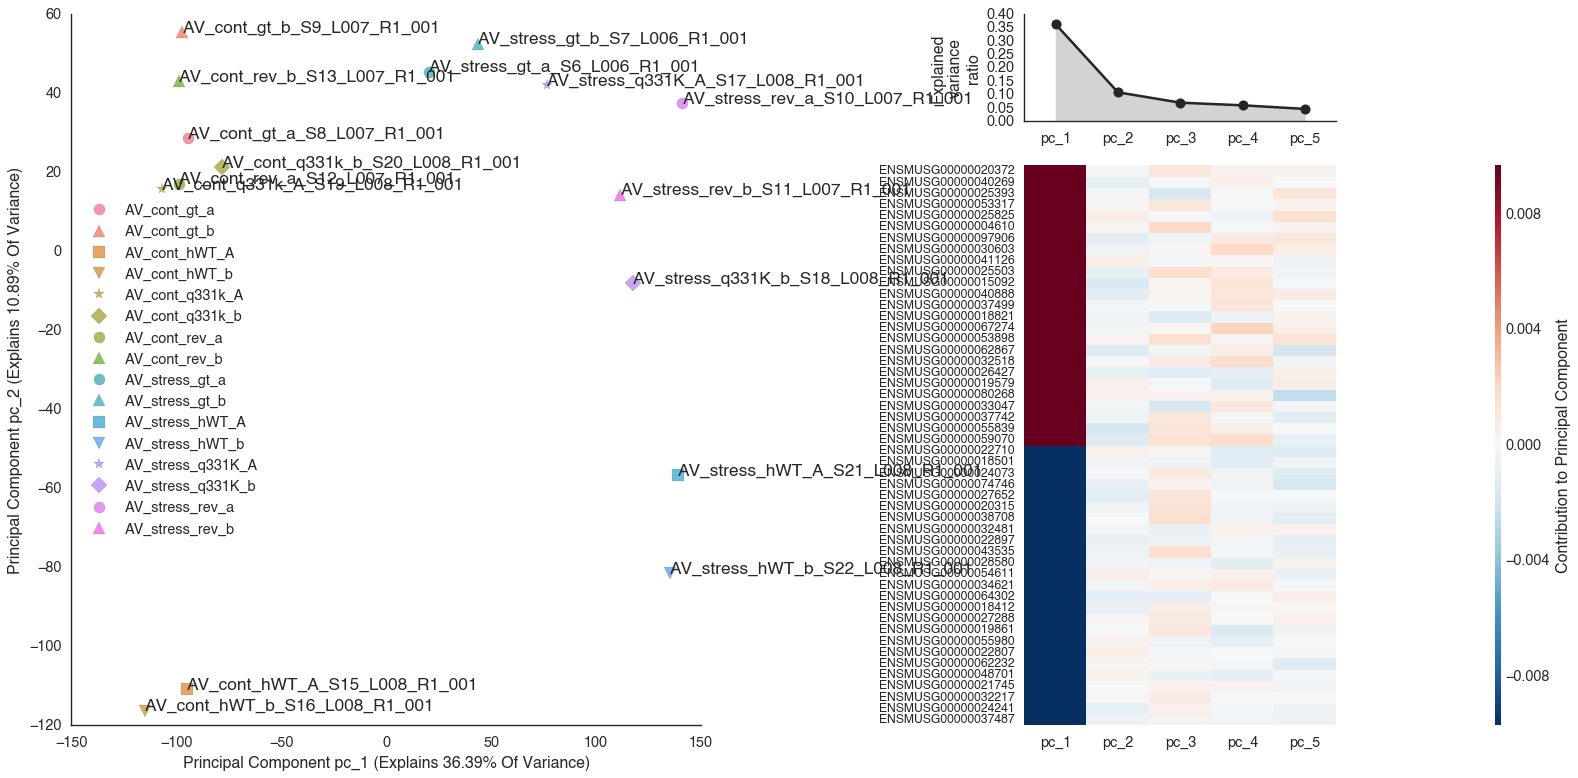

In [125]:
mn_study_stress.plot_pca(feature_subset="all", show_vectors=False, show_point_labels=True)
pyplot.savefig(os.path.join(img_dir, "expression_pca.pdf"))
pyplot.savefig(os.path.join(img_dir, "expression_pca.svg"))

In [128]:
scaled_range = scaled_range.div(scaled_range.sum(axis=0), axis=1).fillna(0)
mn_study_stress_scaled_genes = flotilla.Study(# The metadata describing phenotype and pooled samples
                       metadata,
                       # A version for this data
                       version='0.1.0',
                       expression_data = scaled_range,
                       # Dataframe of the splicing data
                       splicing_data=splicing_df[metadata.date == "june"],
                       expression_thresh = 1,
                       species="mm10"
)

2017-03-03 16:16:37 	Initializing Study
2017-03-03 16:16:37 	Initializing Predictor configuration manager for Study
2017-03-03 16:16:37	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2017-03-03 16:16:37	Added ExtraTreesClassifier to default predictors
2017-03-03 16:16:37	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2017-03-03 16:16:37	Added ExtraTreesRegressor to default predictors
2017-03-03 16:16:37	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2017-03-03 16:16:37	Added GradientBoostingClassifier to default predictors
2017-03-03 16:16:37	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
2017-03-03 16:16:37	Added GradientBoostingRegressor to default predictors
2017-03-03 16:16:37 	Loading metadata
2017-03-03 16:16:37	Loading species metadata from 

No phenotype to color mapping was provided, falling back on reasonable defaults.
No phenotype to marker (matplotlib plotting symbol) was provided, falling back on reasonable defaults.


https://s3-us-west-2.amazonaws.com/flotilla-projects/ercc/ERCC_Controls.txt has not been downloaded before.


Error loading species mm10 data: HTTP Error 404: Not Found

2017-03-03 16:16:39	Loading expression data
2017-03-03 16:16:39	Initializing expression
2017-03-03 16:16:40	Done initializing expression
2017-03-03 16:16:40	Loading splicing data
2017-03-03 16:16:40	Initializing splicing
2017-03-03 16:16:40	Done initializing splicing
2017-03-03 16:16:40	Successfully initialized a Study object!


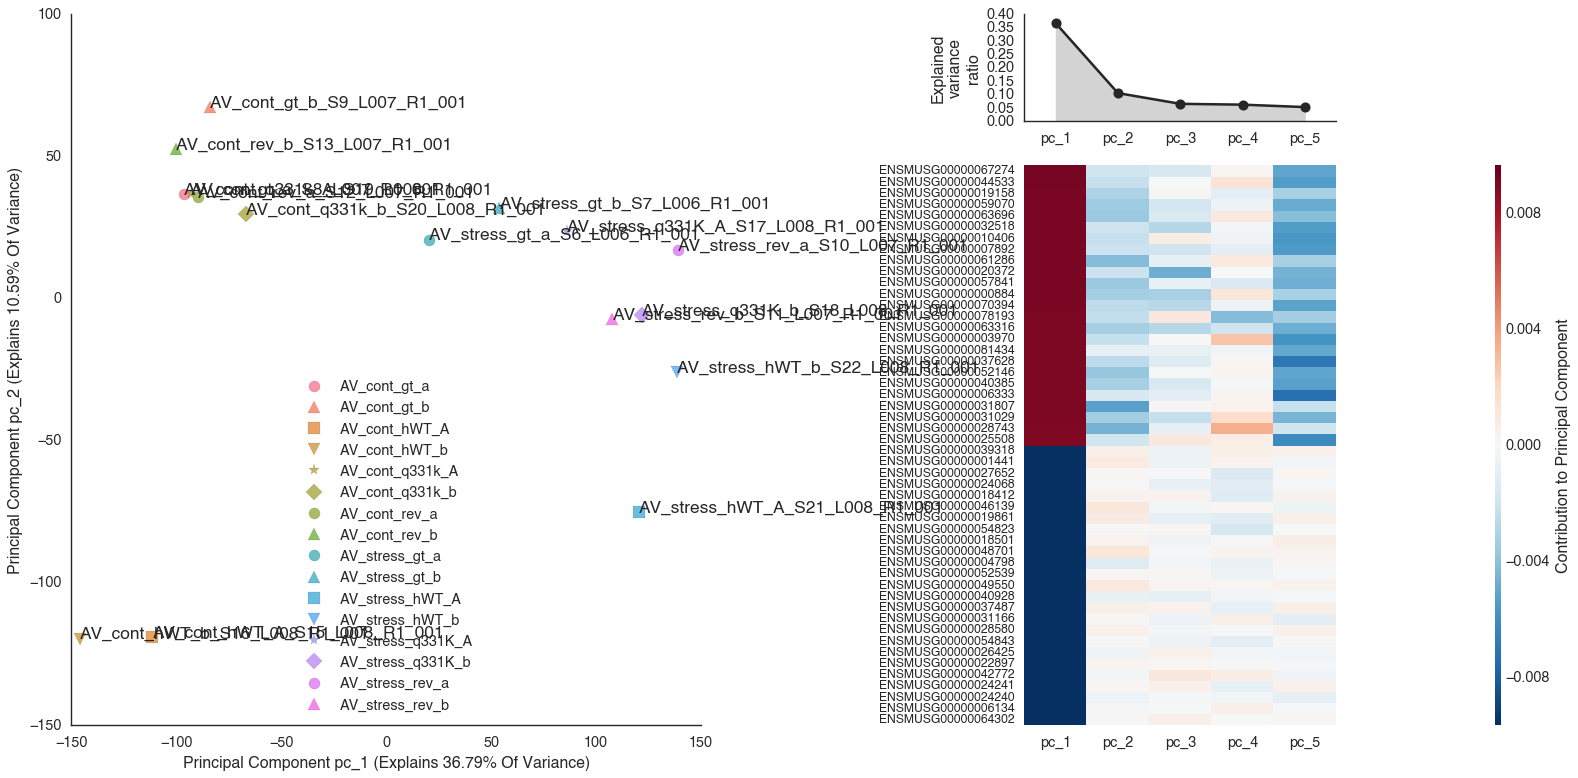

In [129]:
mn_study_stress_scaled_genes.plot_pca(feature_subset="all", show_vectors=False, show_point_labels=True)
pyplot.savefig(os.path.join(img_dir, "expression_scaled_genes_pca.pdf"))
pyplot.savefig(os.path.join(img_dir, "expression_scaled_genes_pca.svg"))

#Plot a few genes

In [130]:
co_downregulated = sig_unstressed_comparison_downregulated.ix['q331k', 'rev'].index & sig_unstressed_comparison_downregulated.ix['q331k', 'hWT'].index & sig_unstressed_comparison_downregulated.ix['q331k', 'gt'].index
co_upregulated = sig_unstressed_comparison_upregulated.ix['q331k', 'rev'].index & sig_unstressed_comparison_upregulated.ix['q331k', 'hWT'].index & sig_unstressed_comparison_upregulated.ix['q331k', 'gt'].index

In [131]:
co_upregulated

Index([u'ENSMUSG00000046721.10', u'ENSMUSG00000011118.3'], dtype='object', name=u'gene_id')

In [132]:
co_downregulated

Index([u'ENSMUSG00000025902.8', u'ENSMUSG00000032487.8',
       u'ENSMUSG00000029231.10', u'ENSMUSG00000030762.6',
       u'ENSMUSG00000048583.11', u'ENSMUSG00000037440.7',
       u'ENSMUSG00000020080.8', u'ENSMUSG00000020908.9',
       u'ENSMUSG00000021944.10', u'ENSMUSG00000044393.10',
       u'ENSMUSG00000024738.5', u'ENSMUSG00000031383.8',
       u'ENSMUSG00000031410.9'],
      dtype='object', name=u'gene_id')

In [133]:
[gene_id_to_name[gene_id] for gene_id in co_downregulated]

['Sox17',
 'Ptgs2',
 'Pdgfra',
 'Aqp8',
 'Igf2',
 'Vnn1',
 'Hkdc1',
 'Myh3',
 'Gata4',
 'Dsg2',
 'Pga5',
 'Dusp9',
 'Nxf7']

In [134]:
sig_unstressed_comparison.xs(name_to_gene_id['Pdgfb'], level='gene_id')

baseMean  log2FoldChange     lfcSE      stat  \
genotype_1 genotype_2                                                    
q331k      gt          7777.303664        0.705885  0.121208  5.823751   
           hWT         8162.334339        0.697282  0.133842  5.209740   

                             pvalue          padj               gene_id  
genotype_1 genotype_2                                                    
q331k      gt          5.754112e-09  4.633790e-07  ENSMUSG00000000489.6  
           hWT         1.891055e-07  7.299571e-06  ENSMUSG00000000489.6

In [135]:
unstressed_comparison.xs(name_to_gene_id['Pdgfb'], level='gene_id')

baseMean  log2FoldChange     lfcSE      stat  \
genotype_1 genotype_2                                                    
hWT        gt          5452.132493        0.091006  0.090625  1.004209   
           rev         6160.854361       -0.216709  0.085813 -2.525367   
q331k      gt          7777.303664        0.705885  0.121208  5.823751   
           hWT         8162.334339        0.697282  0.133842  5.209740   
           rev         8547.932432        0.408442  0.107695  3.792567   
rev        gt          5845.766058        0.265698  0.074939  3.545518   

                             pvalue          padj               gene_id  
genotype_1 genotype_2                                                    
hWT        gt          3.152777e-01  5.221445e-01  ENSMUSG00000000489.6  
           rev         1.155777e-02  5.204719e-02  ENSMUSG00000000489.6  
q331k      gt          5.754112e-09  4.633790e-07  ENSMUSG00000000489.6  
           hWT         1.891055e-07  7.299571e-06  ENSMUSG00000000489.6  
           rev         1.490978e-04  1.743796e-02  ENSMUSG00000000489.6  
rev        gt          3.918417e-04  1.896167e-02  ENSMUSG00000000489.6

In [136]:
plotting_rpkm_df = rpkm_df.xs("june", level="date").xs(False, level="stress")
plotting_rpkm_df = pd.DataFrame(plotting_rpkm_df[['ENSMUSG00000000489', 'ENSMUSG00000048583']].stack())
plotting_rpkm_df['genotype'] = [names[genotype] for genotype in plotting_rpkm_df.index.get_level_values(level="genotype")]
plotting_rpkm_df['gene_id'] = [ensembl_id_to_name[gene_id] for gene_id in plotting_rpkm_df.index.get_level_values(7)]

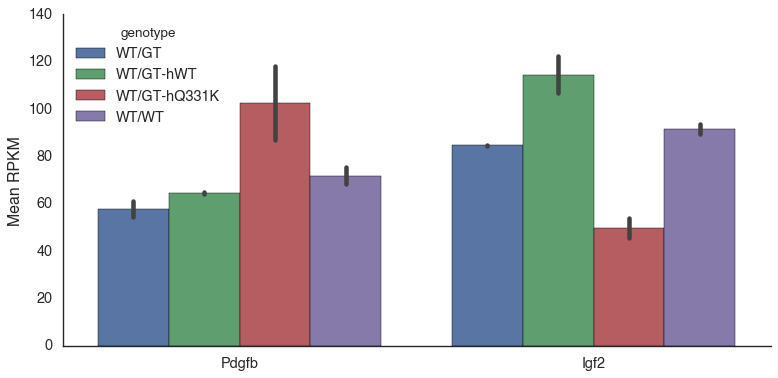

In [137]:
with dataviz.Figure(os.path.join(img_dir, "gene_expression_verification.svg"), figsize=(10, 5)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.barplot(y=0, hue="genotype", x="gene_id", data=plotting_rpkm_df, ax=ax)
    sns.despine(ax=ax)
    ax.set_ylabel("Mean RPKM")
    ax.set_xlabel("")

# MN Panel

In [138]:
neuron_markers = pd.read_excel("/home/gpratt/Dropbox/TAF15/Data/mouse_integration/13-02-12 Neuron 96 marker panel.xlsx", "Sheet2")
neuron_markers = neuron_markers.dropna(subset=["Accession Number"])

name_to_gene_id = {value: key for key, value in gene_id_to_name.items()} 
ensembl_to_refseq = pd.read_table("/home/gpratt/Dropbox/TAF15/Data/mouse_integration/ensembl_to_refseq.txt.gz").dropna()
refseq_to_gencode = {row['RefSeq mRNA [e.g. NM_001195597]']: row['Ensembl Gene ID'] for name, row in ensembl_to_refseq.iterrows()}
ensembl_to_refseq = {value: key for key, value in refseq_to_gencode.items()} 
ensembl_to_gencode_hg19 = {key.split(".")[0]: key for key in gene_id_to_name_hg19}


In [139]:
def map_to_mouse(gene):
    try:
        gene =  human_mouse_genes.ix[gene]["Ensembl Gene ID"]
        return gene[0] if type(gene) != str else gene
    except:
        return np.nan
    
mouse_human_genes = pd.read_table("/home/gpratt/mouse_human_genes.txt", index_col=0)
#mouse_gene_id_names = pd.read_table("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/mouse_gene_id_to_names.txt", index_col=0)
human_mouse_genes = pd.read_table("/home/gpratt/mouse_human_genes.txt", index_col=2)


In [140]:
result = []
for name, row in neuron_markers.iterrows():
    if not row.isnull().gencode:
        ensembl = row.gencode.strip().split(".")[0]
    else:
        ensembl = refseq_to_gencode[row['Accession Number'].strip()]
        
    result.append(ensembl_to_gencode_hg19[ensembl])
    
neuron_markers['gencode_id'] = result
neuron_markers['ensembl_id'] = neuron_markers.gencode_id.apply(lambda x: x.split(".")[0])
neuron_markers['mouse_id'] = neuron_markers.ensembl_id.apply(map_to_mouse)

In [141]:
gencode_to_gene_symbol = dict(zip(neuron_markers.mouse_id, neuron_markers['Gene Symbol']))

In [142]:
neuron_markers = neuron_markers.dropna(axis=0, subset=["mouse_id"])

In [150]:
neuronal_df = rpkm_df[[not x for x in rpkm_df.index.get_level_values("stress")]]
neuronal_df = neuronal_df[neuron_markers.mouse_id]
neuronal_df.index = sample_names
neuronal_df.columns = [gencode_to_gene_symbol[gene_id] for gene_id in neuronal_df.columns]

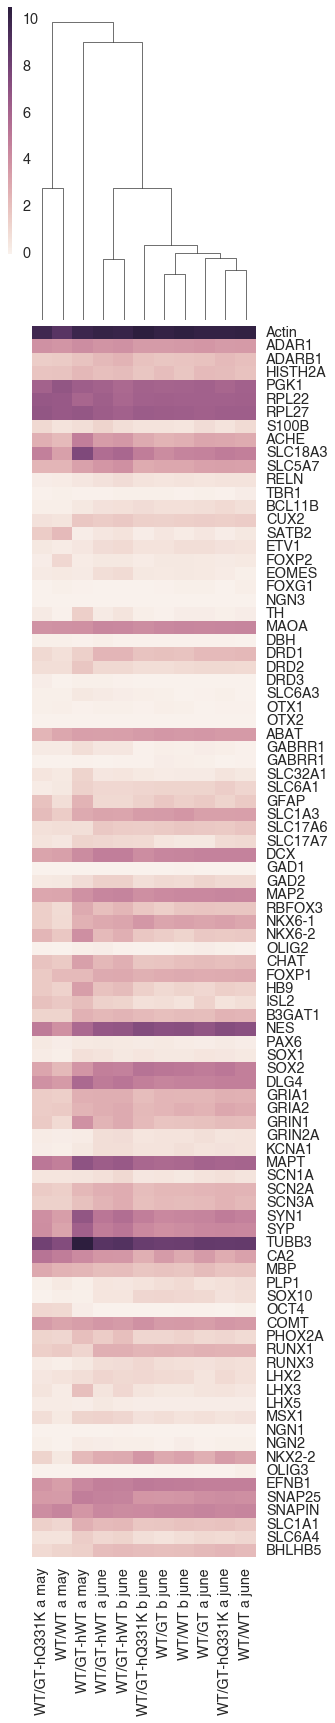

In [164]:
fig = sns.clustermap(np.log2(neuronal_df + 1).T, row_cluster=False, figsize=(4, 25))
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
fig.savefig(os.path.join(img_dir, "mn_clustering.svg"), figsize=(3,3))
fig.savefig(os.path.join(img_dir, "mn_clustering.pdf"), figsize=(3,3))